In [1]:
import os
import random
import shutil
import tarfile

import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns
from networkx.algorithms import core, assortativity
from powerlaw import Fit

## Load the dataset (download and extract manually if needed)

#### Define URLs and filenames

In [2]:
dataset_url = "http://konect.cc/files/download.tsv.maayan-Stelzl.tar.bz2"
compressed_file = "download.tsv.maayan-Stelzl.tar.bz2"
extracted_folder = "maayan-Stelzl"  # The default extracted folder name
final_folder = "stelzl"  # The new name for the extracted data
metrics_folder = "stelzl_metrics"

#### Download the dataset

In [3]:
if not os.path.exists(compressed_file):
    print(f"Downloading {compressed_file}...")
    response = requests.get(dataset_url, stream=True)
    with open(compressed_file, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print("Download complete.")

Download complete.


#### Extract the tar.bz2 file

In [4]:
if not os.path.exists(extracted_folder):
    print("Extracting dataset...")
    with tarfile.open(compressed_file, "r:bz2") as tar:
        tar.extractall()
    print("Extraction complete.")

Extracting dataset...
Extraction complete.


In [5]:
if not os.path.exists(metrics_folder):
    os.mkdir(metrics_folder)

#### Rename the extracted folder

In [6]:
if os.path.exists(extracted_folder):
    if os.path.exists(final_folder):
        shutil.rmtree(final_folder)  # Remove existing folder if present
    os.rename(extracted_folder, final_folder)
    print(f"Folder renamed to {final_folder}.")

Folder renamed to stelzl.


## Load Network

#### Load dataset

In [7]:
file_path = os.path.join(final_folder, "out.maayan-Stelzl")
df = pd.read_csv(
        file_path, sep="\s+", comment="%", names=["source", "target"]
)  # sep="\s+": It automatically handles cases where extra spaces exist.

df.head()

source  target
0       1       2
1       3       4
2       5       6
3       7       8
4       9      10

#### Create a directed graph

In [8]:
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row["source"], row["target"])

print(
        f"Loaded network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
)

Loaded network with 1706 nodes and 6207 edges.


In [9]:
G_dup = G.copy()

In [10]:
# Check if the network is directed
is_directed = G.is_directed()

# Check if it contains reciprocal edges (which would indicate undirected behavior)
reciprocal_edges = sum(1 for u, v in G.edges() if G.has_edge(v, u))

is_directed, reciprocal_edges

(True, 6068)

In [11]:
nx.write_gexf(G_dup, "Graph_directed.gexf")

In [12]:
# Display basic information
print(f"Number of proteins (nodes): {G.number_of_nodes()}")
print(f"Number of interactions (edges): {G.number_of_edges()}")

Number of proteins (nodes): 1706
Number of interactions (edges): 6207


## Validity and Reliability

In [13]:
# Check for self-loops and multiple edges
print(f"Self-loops: {nx.number_of_selfloops(G)}")
print(f"Graph Density: {nx.density(G)}")

Self-loops: 36
Graph Density: 0.002133920989572769


## Compute Centrality Measures

Top 10 Proteins by
* Degree Centrality – Degree Centrality (Most Interacting Proteins).
* Closeness Centrality – (Most Efficiently Connected Proteins)
* Betweenness Centrality – (Key Connectors)
* Eigenvector Centrality – (Most Influential Proteins)

In [14]:
print("Computing centrality measures...")

# Compute Centrality Measures
degree_centrality = nx.degree_centrality(G)  # Measures direct connectivity
betweenness_centrality = nx.betweenness_centrality(G)  # Finds key hubs
closeness_centrality = nx.closeness_centrality(G)  # Measures travel efficiency
eigenvector_centrality = nx.eigenvector_centrality(
        G, max_iter=1000
)  # Measures influence

# Store results in a DataFrame
centrality_df = pd.DataFrame(
        {
            "Node": list(G.nodes),
            "Degree": [degree_centrality[n] for n in G.nodes],
            "Betweenness": [betweenness_centrality[n] for n in G.nodes],
            "Closeness": [closeness_centrality[n] for n in G.nodes],
            "Eigenvector": [eigenvector_centrality[n] for n in G.nodes],
        }
)

# Save results to CSV
centrality_df.to_csv(f"{metrics_folder}/centrality_measures.csv", index=False)
print("Centrality measures saved to 'centrality_measures.csv'.")

# Print Top 10 most central proteins
print("\nTop 10 Proteins by Degree Centrality:")
print(centrality_df.sort_values("Degree", ascending=False).head(10))
# print(centrality_df.sort_values("Degree", ascending=False).head(10)['Node'].to_list()) ## Just the list of nodes

print("\nTop 10 Proteins by Betweenness Centrality:")
print(centrality_df.sort_values("Betweenness", ascending=False).head(10))

print("\nTop 10 Proteins by Closeness Centrality:")
print(centrality_df.sort_values("Closeness", ascending=False).head(10))

print("\nTop 10 Proteins by Eigenvector Centrality:")
print(centrality_df.sort_values("Eigenvector", ascending=False).head(10))

Computing centrality measures...
Centrality measures saved to 'centrality_measures.csv'.

Top 10 Proteins by Degree Centrality:
     Node    Degree  Betweenness  Closeness  Eigenvector
66     67  0.110850     0.068413   0.268967     0.268426
30     31  0.083871     0.038383   0.261225     0.227999
12     13  0.082111     0.066737   0.264669     0.114819
195   196  0.077419     0.052485   0.264880     0.179868
53     54  0.075660     0.033696   0.255236     0.178774
62     63  0.072727     0.063427   0.265145     0.120993
141   142  0.066862     0.031723   0.253188     0.168824
268   269  0.063343     0.068434   0.266372     0.108981
10     11  0.061584     0.035575   0.250887     0.152326
49     50  0.061584     0.048156   0.261276     0.060120

Top 10 Proteins by Betweenness Centrality:
     Node    Degree  Betweenness  Closeness  Eigenvector
268   269  0.063343     0.068434   0.266372     0.108981
66     67  0.110850     0.068413   0.268967     0.268426
12     13  0.082111     0.0667

In [15]:
print("Top 10 Proteins by Degree Centrality:")
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for protein, score in top_degree:
    print(f"{protein}: {score:.4f}")

Top 10 Proteins by Degree Centrality:
67: 0.1109
31: 0.0839
13: 0.0821
196: 0.0774
54: 0.0757
63: 0.0727
142: 0.0669
269: 0.0633
11: 0.0616
50: 0.0616


In [16]:
top_betweenness = sorted(
        betweenness_centrality.items(), key=lambda x: x[1], reverse=True
)[:10]

print("Top 10 Proteins by Betweenness Centrality:")
for protein, score in top_betweenness:
    print(f"{protein}: {score:.4f}")

Top 10 Proteins by Betweenness Centrality:
269: 0.0684
67: 0.0684
13: 0.0667
63: 0.0634
196: 0.0525
50: 0.0482
150: 0.0412
157: 0.0397
31: 0.0384
328: 0.0374


In [17]:
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[
                :10
                ]

print("Top 10 Proteins by Closeness Centrality:")
for protein, score in top_closeness:
    print(f"{protein}: {score:.4f}")

Top 10 Proteins by Closeness Centrality:
150: 0.2832
244: 0.2759
67: 0.2690
342: 0.2685
269: 0.2664
159: 0.2655
347: 0.2655
63: 0.2651
196: 0.2649
13: 0.2647


In [18]:
print("Top 10 Proteins by Eigenvector Centrality:")
top_eigenvector = sorted(
        eigenvector_centrality.items(), key=lambda x: x[1], reverse=True
)[:10]

for protein, score in top_eigenvector:
    print(f"{protein}: {score:.4f}")

Top 10 Proteins by Eigenvector Centrality:
67: 0.2684
31: 0.2280
150: 0.1869
196: 0.1799
54: 0.1788
142: 0.1688
123: 0.1667
118: 0.1600
347: 0.1574
244: 0.1558


Visualize the top 10 Proteins for Each Centrality Measure

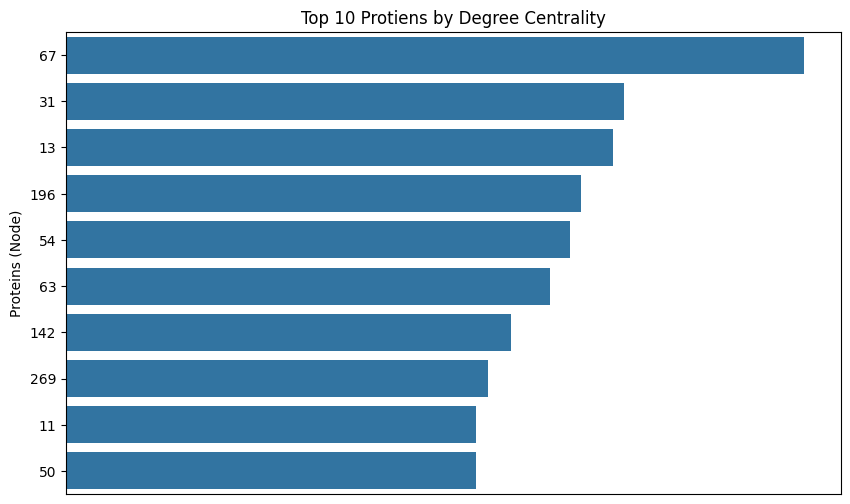

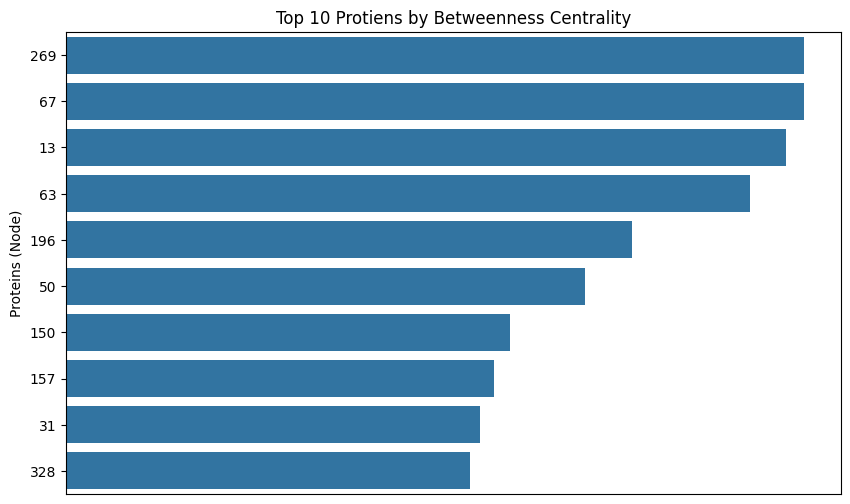

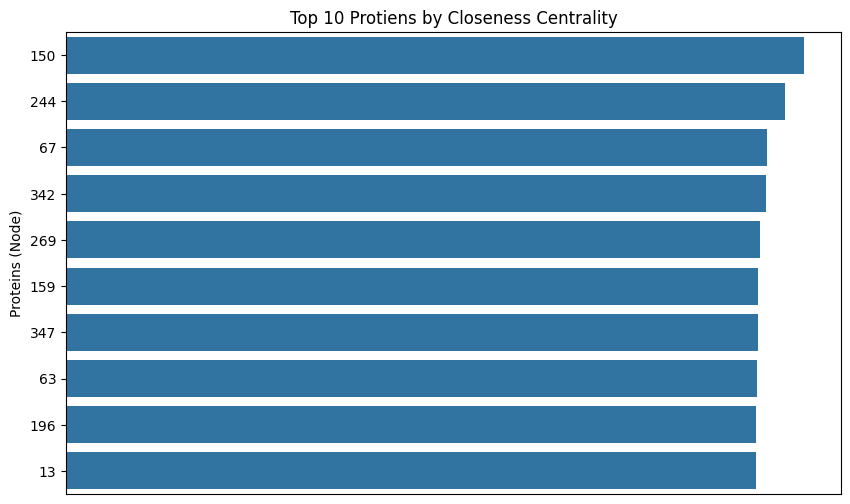

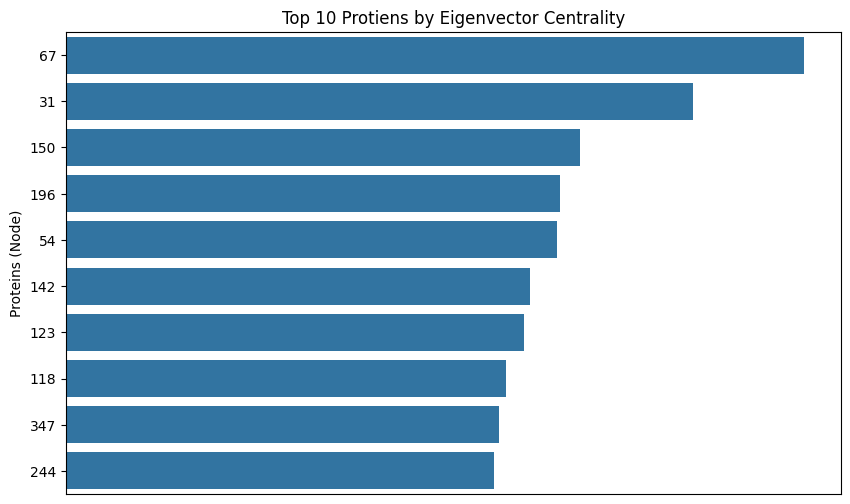

In [19]:
# Load the computed centrality measures
centrality_df = pd.read_csv(f"{metrics_folder}/centrality_measures.csv")

# Select the top 10 proteins for each centrality measure
top_degree = centrality_df.nlargest(10, "Degree")
top_betweenness = centrality_df.nlargest(10, "Betweenness")
top_closeness = centrality_df.nlargest(10, "Closeness")
top_eigenvector = centrality_df.nlargest(10, "Eigenvector")


# Function to create improved bar plots
def plot_centrality(df, column, title, color="blue"):
    plt.figure(figsize=(10, 6))
    sns.barplot(y=df["Node"].astype(str), x=df[column], legend=False)
    plt.ylabel("Proteins (Node)")
    plt.xlabel("")  # Remove x-axis label
    plt.title(title)
    plt.xticks([])  # Hide x-axis values for better clarity
    plt.grid(axis="x", linestyle="--", alpha=0.5)  # Add subtle grid for readability
    plt.show()


# Plot the Top 10 Proteins for Each Centrality Measure
plot_centrality(top_degree, "Degree", "Top 10 Protiens by Degree Centrality")
plot_centrality(
        top_betweenness,
        "Betweenness",
        "Top 10 Protiens by Betweenness Centrality",
        color="red",
)
plot_centrality(
        top_closeness, "Closeness", "Top 10 Protiens by Closeness Centrality", color="green"
)
plot_centrality(
        top_eigenvector,
        "Eigenvector",
        "Top 10 Protiens by Eigenvector Centrality",
        color="purple",
)

Correlation between centrality measures (Degree, Betweenness, Closeness, Eigenvector)

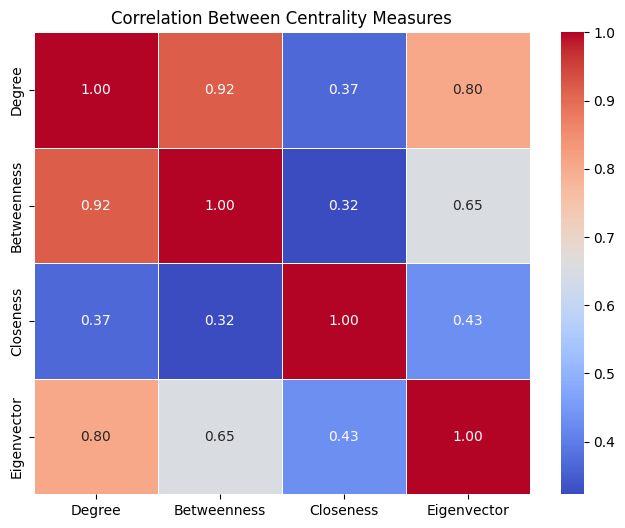

In [20]:
# Load computed centrality measures
centrality_df = pd.read_csv(f"{metrics_folder}/centrality_measures.csv")

# Compute the correlation matrix
correlation_matrix = centrality_df[
    ["Degree", "Betweenness", "Closeness", "Eigenvector"]
].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Centrality Measures")
plt.show()

Correlation with more centrality mesures
* The Katz centrality computation failed to converge because the alpha=0.1 parameter is too high, leading to instability in the power iteration process. Katz centrality requires alpha to be less than 1/λ_max, where λ_max is the largest eigenvalue of the adjacency matrix.

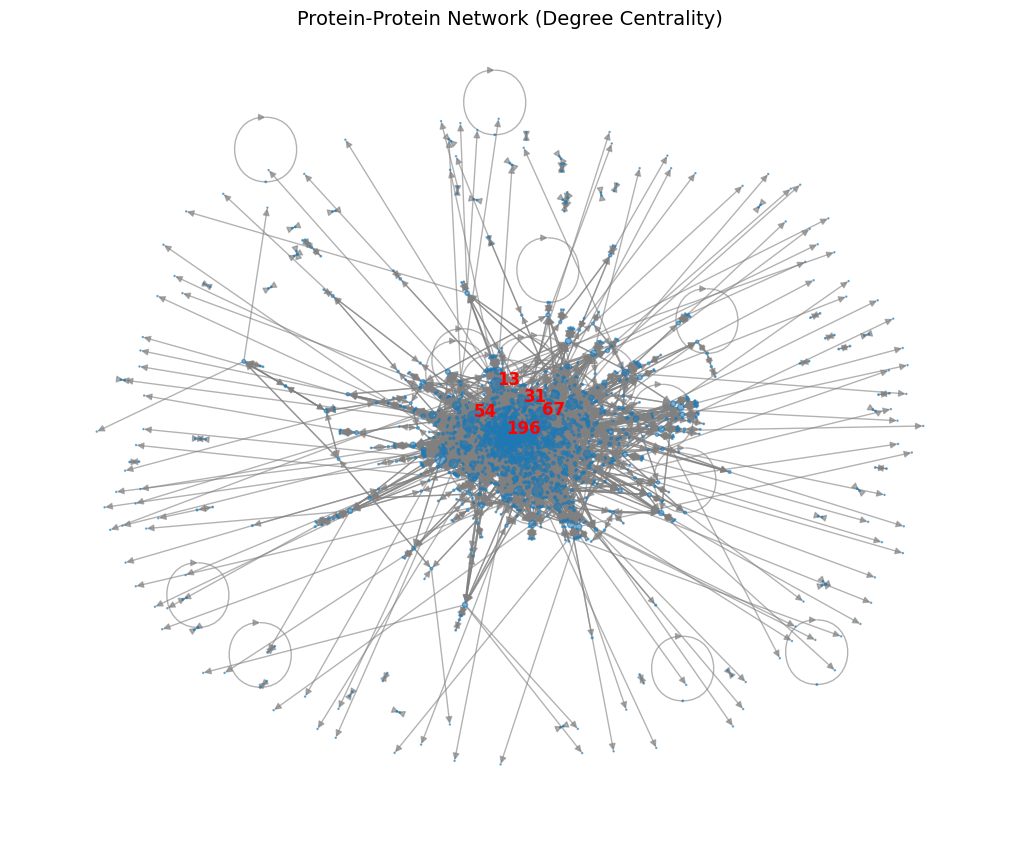

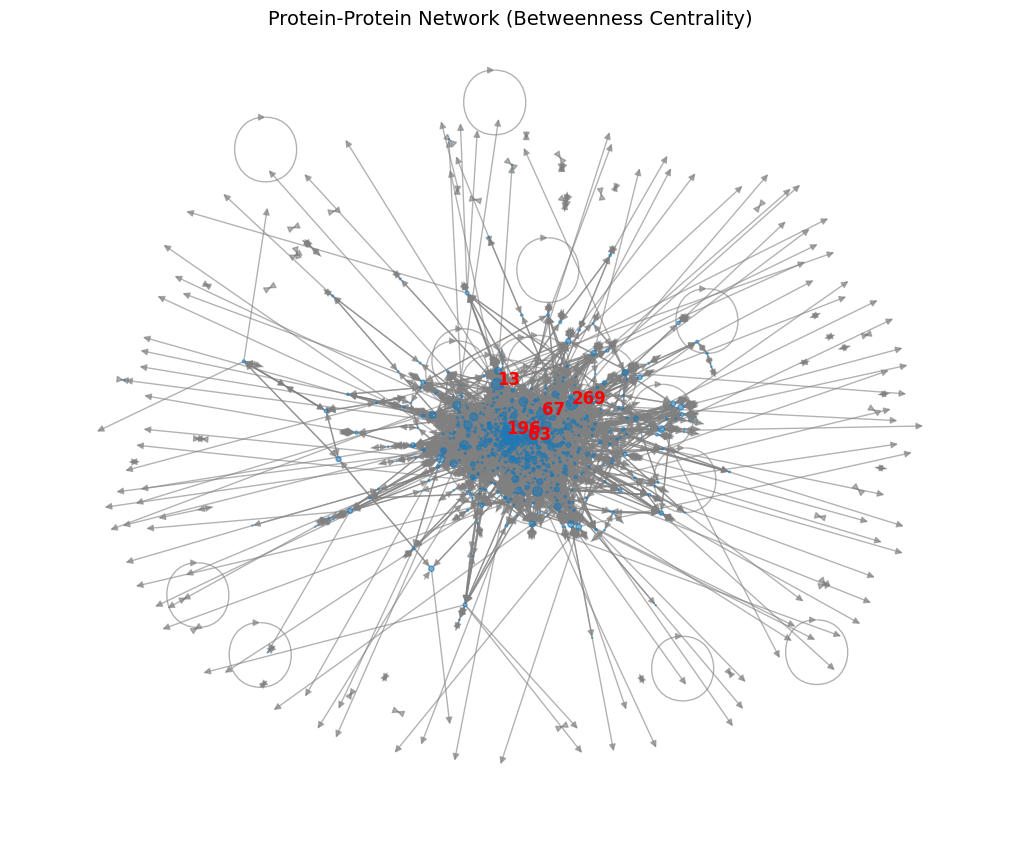

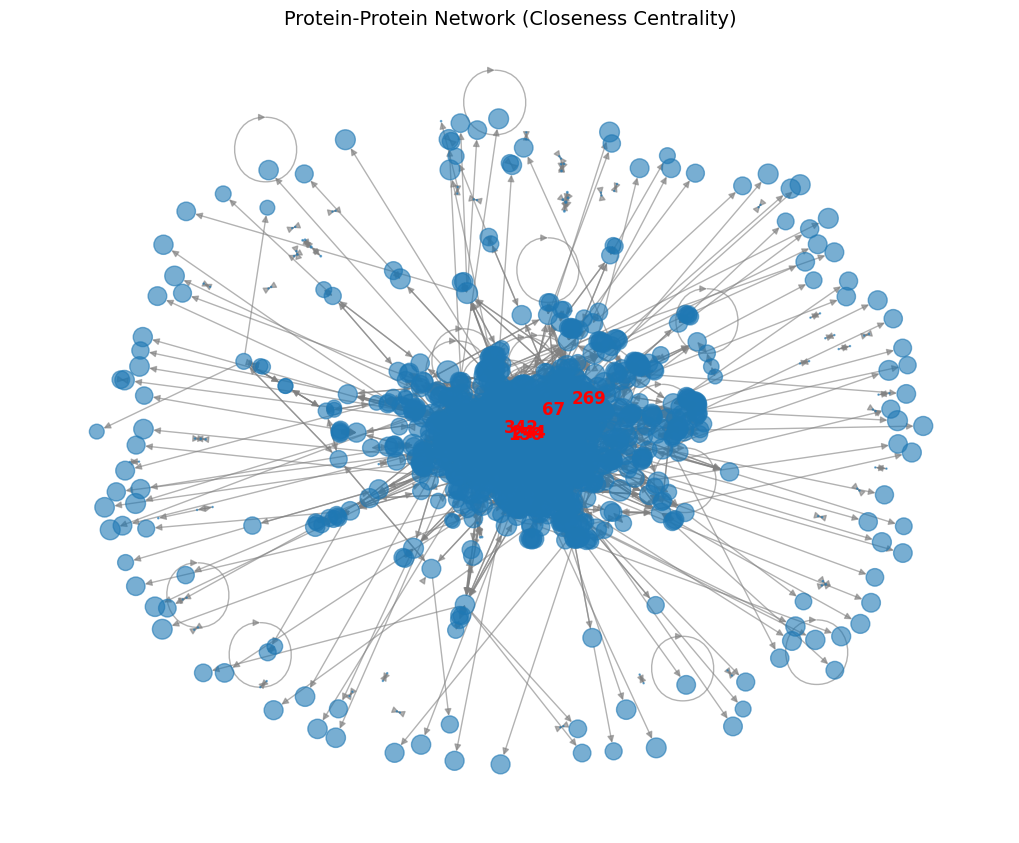

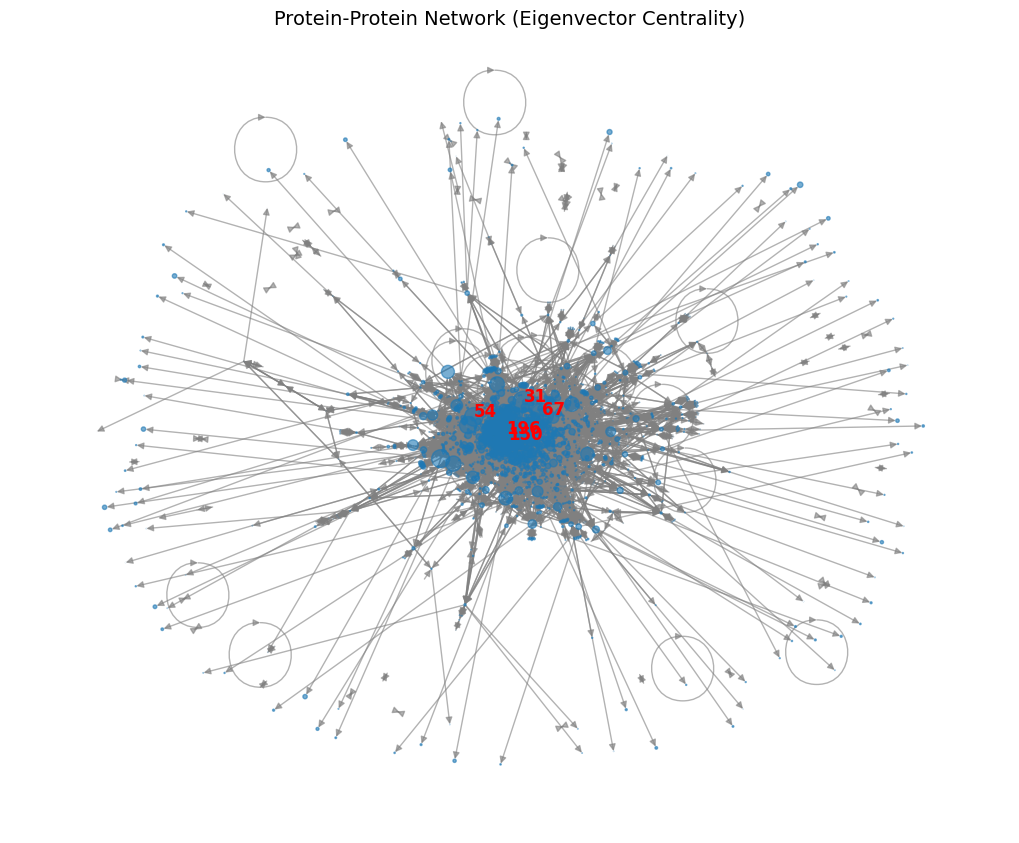

In [21]:
# Function to get top nodes based on centrality measure
def get_top_nodes(centrality_dict, top_n=5):
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]


# Get the top 5 proteins for each centrality measure
top_degree = get_top_nodes(degree_centrality)
top_betweenness = get_top_nodes(betweenness_centrality)
top_closeness = get_top_nodes(closeness_centrality)
top_eigenvector = get_top_nodes(eigenvector_centrality)

# Normalize values for visualization
max_size = 1000  # Maximum node size in plot
degree_size = [max_size * degree_centrality[node] for node in G.nodes()]
betweenness_size = [max_size * betweenness_centrality[node] for node in G.nodes()]
closeness_size = [max_size * closeness_centrality[node] for node in G.nodes()]
eigenvector_size = [max_size * eigenvector_centrality[node] for node in G.nodes()]


# Function to draw network with top nodes labeled
def draw_network(G, node_size, title, top_nodes):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Layout for visualization
    nx.draw(
            G, pos, node_size=node_size, with_labels=False, edge_color="gray", alpha=0.6
    )

    # Annotate top nodes
    for node, _ in top_nodes:
        x, y = pos[node]
        plt.text(x, y, node, fontsize=12, fontweight="bold", color="red")

    plt.title(title, fontsize=14)
    plt.show()


# Visualize and annotate each centrality measure
draw_network(G, degree_size, "Protein-Protein Network (Degree Centrality)", top_degree)
draw_network(
        G,
        betweenness_size,
        "Protein-Protein Network (Betweenness Centrality)",
        top_betweenness,
)
draw_network(
        G, closeness_size, "Protein-Protein Network (Closeness Centrality)", top_closeness
)
draw_network(
        G,
        eigenvector_size,
        "Protein-Protein Network (Eigenvector Centrality)",
        top_eigenvector,
)

In [22]:
# Compute largest eigenvalue of the adjacency matrix
largest_eigenvalue = max(np.linalg.eigvals(nx.to_numpy_array(G)))

# Set alpha to be slightly less than 1/largest_eigenvalue
alpha = 0.85 / largest_eigenvalue  # Adjust scaling factor if needed

# Compute Katz Centrality with safe alpha
try:
    katz_centrality = nx.katz_centrality(G, alpha=alpha, beta=1.0, max_iter=1000)
    print("Katz centrality computed successfully.")
except nx.PowerIterationFailedConvergence:
    print("Katz centrality still failed to converge. Try reducing alpha further.")

Katz centrality computed successfully.


c:\Users\Ali\Desktop\SNA\venv\lib\site-packages\networkx\algorithms\centrality\katz.py:186: ComplexWarning: Casting complex values to real discards the imaginary part
  s = 1.0 / math.hypot(*x.values())


c:\Users\Ali\Desktop\SNA\venv\lib\site-packages\pandas\core\internals\managers.py:1753: ComplexWarning: Casting complex values to real discards the imaginary part
  result[rl.indexer] = arr
c:\Users\Ali\Desktop\SNA\venv\lib\site-packages\numpy\_core\_methods.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


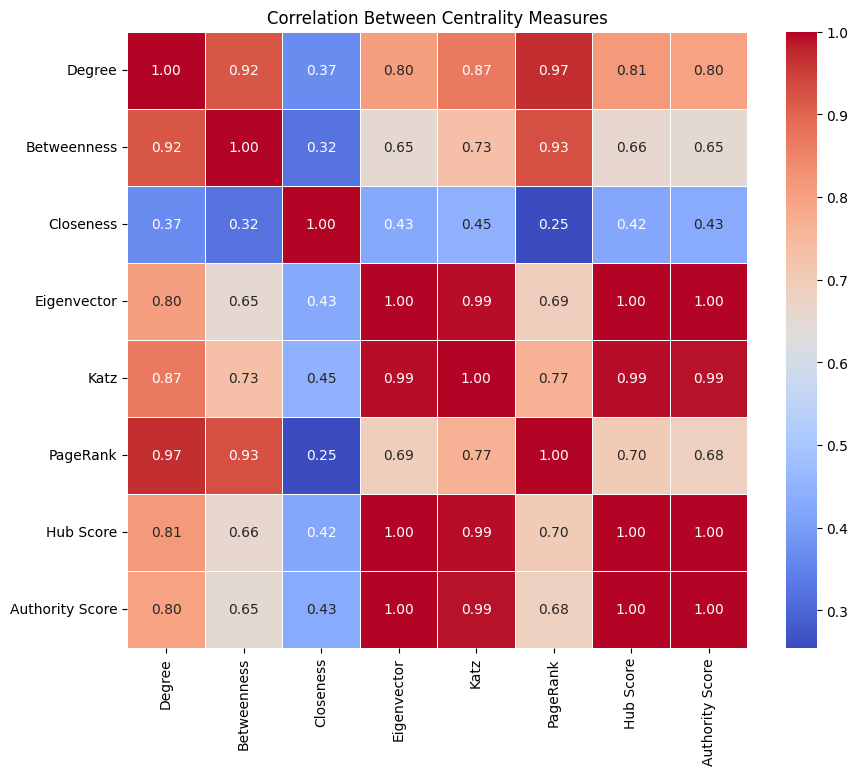

Correlation matrix with standard deviations saved as 'centrality_correlation_matrix.csv'.


In [23]:
# Compute Additional Centrality Measures
# katz_centrality = nx.katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000)  # not converging because of big alpha
pagerank_centrality = nx.pagerank(G)
hub_scores, authority_scores = nx.hits(G, max_iter=1000)

# Load previously computed centralities
centrality_df = pd.read_csv(f"{metrics_folder}/centrality_measures.csv")

# Add new metrics
centrality_df["Katz"] = [katz_centrality[n] for n in G.nodes]
centrality_df["PageRank"] = [pagerank_centrality[n] for n in G.nodes]
centrality_df["Hub Score"] = [hub_scores[n] for n in G.nodes]
centrality_df["Authority Score"] = [authority_scores[n] for n in G.nodes]

# Compute Correlation Matrix
correlation_matrix = centrality_df.drop(columns=["Node"]).corr()

# Compute Standard Deviations
std_devs = centrality_df.drop(columns=["Node"]).std()

# Format correlation matrix with std deviations
correlation_table = correlation_matrix.copy()
correlation_table["Std Dev."] = std_devs  # Add standard deviation as the last column

# Save to CSV
correlation_table.to_csv(f"{metrics_folder}/centrality_correlation_matrix.csv", index=True)

# Display table
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Centrality Measures")
plt.show()

print(
        "Correlation matrix with standard deviations saved as 'centrality_correlation_matrix.csv'."
)

## Clique analysis

In [24]:
print("Finding maximal cliques...")

G = G_dup.copy()

# Convert to an undirected graph (since cliques are fully connected subgraphs)
G_undirected = G.to_undirected()

# Find all maximal cliques
cliques = list(nx.find_cliques(G_undirected))

# Sort cliques by size (largest first)
sorted_cliques = sorted(cliques, key=len, reverse=True)

# Find the largest cliques
largest_cliques = sorted_cliques[:10]  # Top 10 largest cliques

# Save clique data
clique_sizes = [len(c) for c in cliques]
clique_df = pd.DataFrame({"Clique Size": clique_sizes})
clique_df.to_csv(f"{metrics_folder}/clique_sizes.csv", index=False)

# Display results
print(f"Total number of cliques: {len(cliques)}")
print(f"Largest clique size: {len(largest_cliques[0])} (fully connected proteins)")
print(f"Top 10 Largest Cliques (each row is a fully connected group of proteins):")
for i, clique in enumerate(largest_cliques):
    print(
            f"Clique {i + 1} ({len(clique)} nodes): {[int(node_number) for node_number in clique]}"
    )

Finding maximal cliques...
Total number of cliques: 3040
Largest clique size: 4 (fully connected proteins)
Top 10 Largest Cliques (each row is a fully connected group of proteins):
Clique 1 (4 nodes): [13, 50, 70, 150]
Clique 2 (3 nodes): [7, 8, 118]
Clique 3 (3 nodes): [11, 147, 153]
Clique 4 (3 nodes): [11, 150, 257]
Clique 5 (3 nodes): [11, 150, 609]
Clique 6 (3 nodes): [13, 419, 150]
Clique 7 (3 nodes): [13, 50, 579]
Clique 8 (3 nodes): [13, 50, 197]
Clique 9 (3 nodes): [13, 50, 175]
Clique 10 (3 nodes): [13, 50, 26]


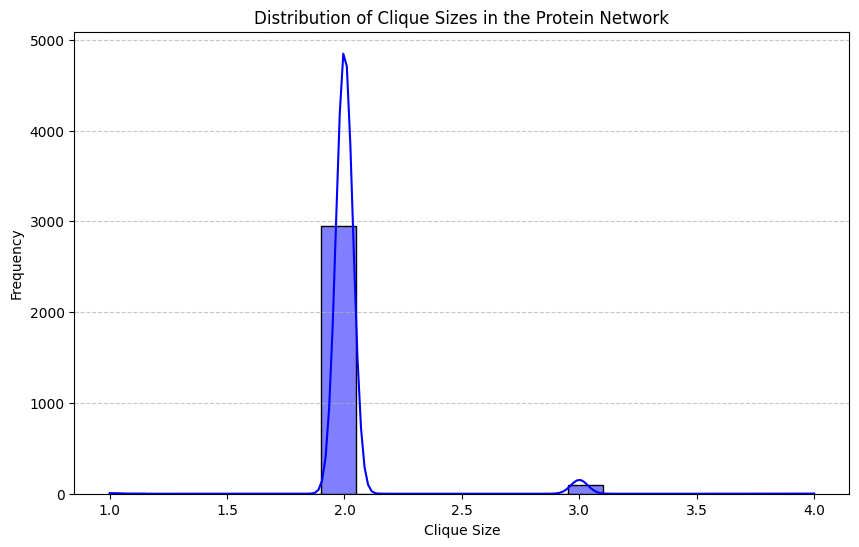

In [25]:
# Load clique sizes
clique_sizes = pd.read_csv(f"{metrics_folder}/clique_sizes.csv")

# Plot histogram of clique sizes
plt.figure(figsize=(10, 6))
sns.histplot(clique_sizes["Clique Size"], bins=20, kde=True, color="blue")
plt.xlabel("Clique Size")
plt.ylabel("Frequency")
plt.title("Distribution of Clique Sizes in the Protein Network")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Visualize the two largest cliques

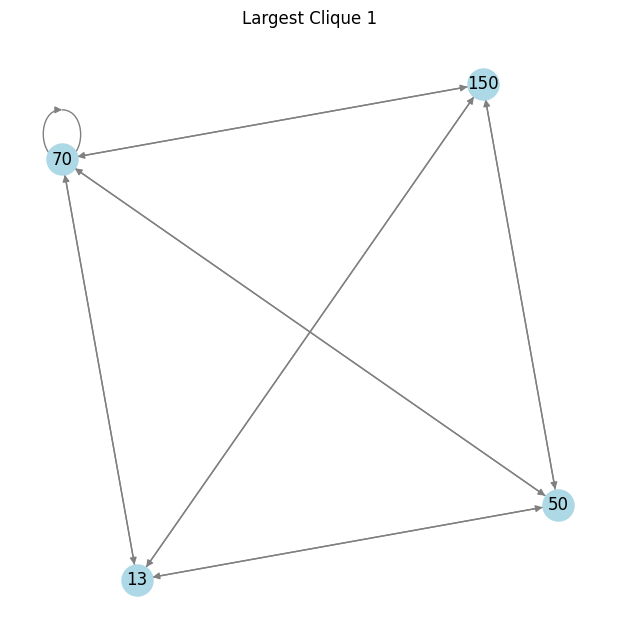

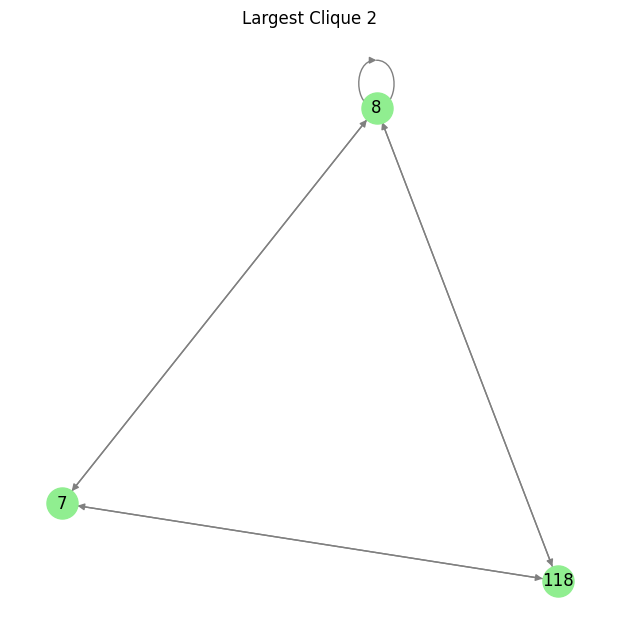

In [26]:
# Extract the two largest cliques
largest_cliques = sorted_cliques[:2]  # Only the top 2


# Function to plot a clique
def plot_clique(clique, title, color="lightblue"):
    plt.figure(figsize=(6, 6))
    subgraph = G.subgraph(clique)
    pos = nx.spring_layout(subgraph)
    nx.draw(
            subgraph,
            pos,
            with_labels=True,
            node_color=color,
            edge_color="gray",
            node_size=500,
    )
    plt.title(title)
    plt.show()


# Plot the two largest cliques
plot_clique(largest_cliques[0], "Largest Clique 1", color="lightblue")
plot_clique(largest_cliques[1], "Largest Clique 2", color="lightgreen")

Visualize the number of times each protein appears in a clique

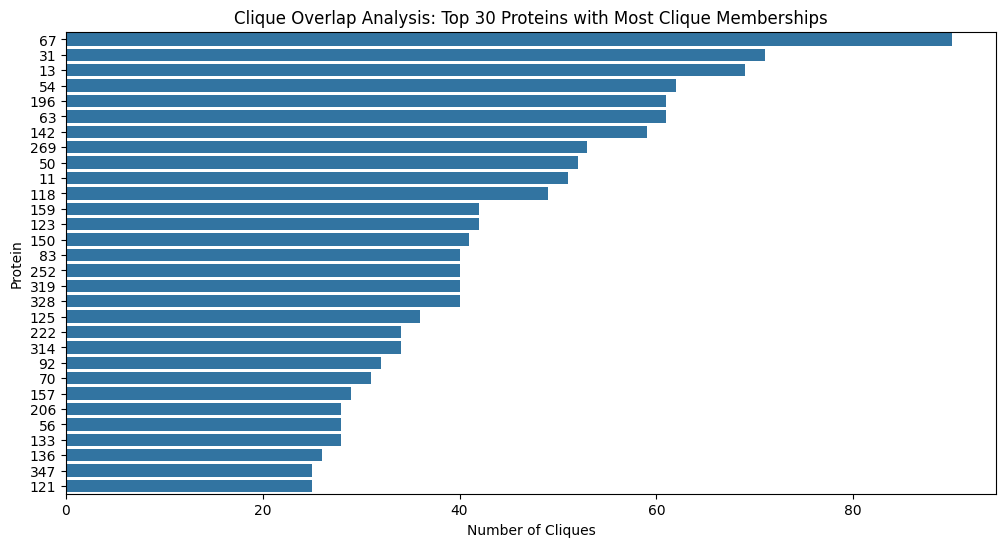

In [27]:
PLOT_FOR_ONLY = 30

# Count the number of times each protein appears in a clique
clique_participation = {}
for clique in cliques:
    for node in clique:
        clique_participation[node] = clique_participation.get(node, 0) + 1

# Convert to DataFrame
clique_df = pd.DataFrame(
        list(clique_participation.items()), columns=["Protein", "Num_Cliques"]
)

# Sort by number of cliques and take the top 30 proteins
top_clique_participation = clique_df.sort_values("Num_Cliques", ascending=False).head(
        PLOT_FOR_ONLY
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
        y=top_clique_participation["Protein"].astype(str),
        x=top_clique_participation["Num_Cliques"],
)
plt.xlabel("Number of Cliques")
plt.ylabel("Protein")
plt.title(
        f"Clique Overlap Analysis: Top {PLOT_FOR_ONLY} Proteins with Most Clique Memberships"
)
plt.show()

Visualize maximum clique size per protein

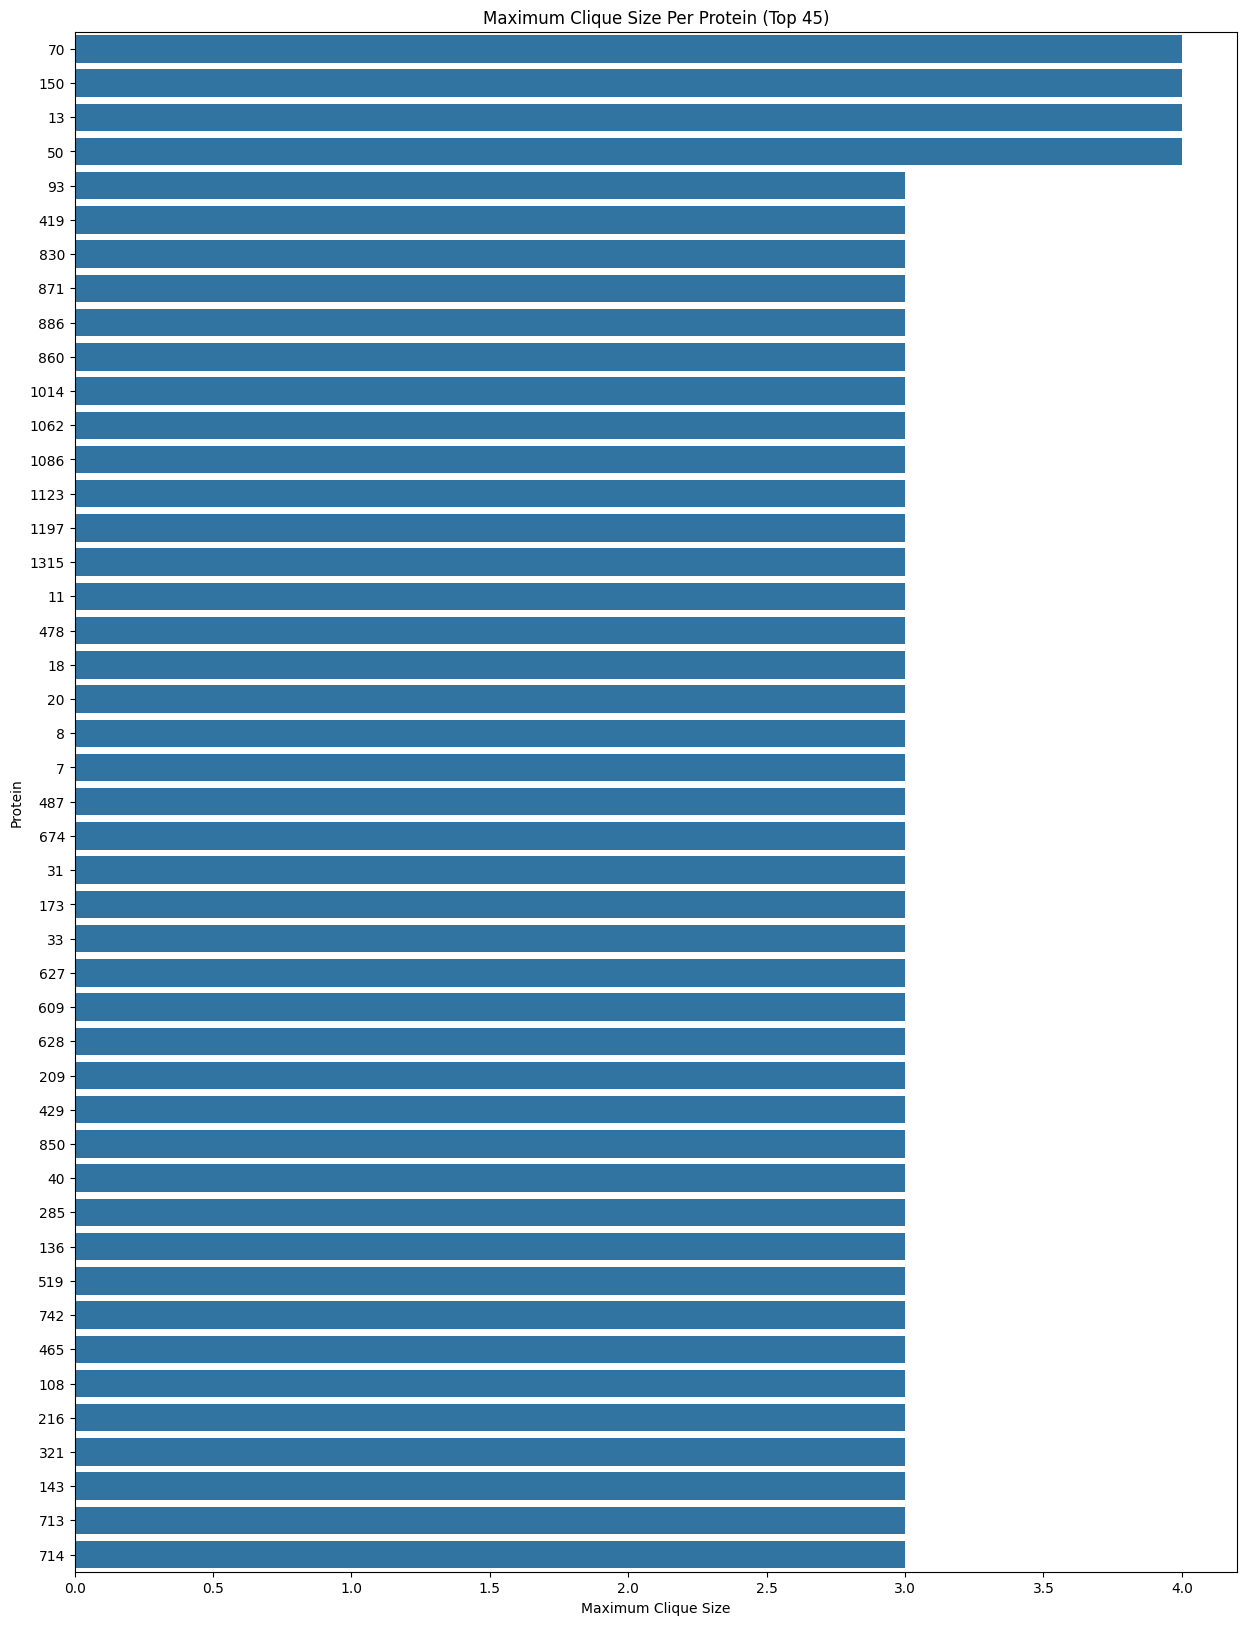

In [28]:
PLOT_FOR_ONLY = 45

# Compute maximum clique size per protein
max_clique_size = {
    node: max([len(clique) for clique in cliques if node in clique]) for node in G.nodes
}

# Convert to DataFrame
max_clique_df = pd.DataFrame(
        list(max_clique_size.items()), columns=["Protein", "Max_Clique_Size"]
)
max_clique_df = max_clique_df.sort_values("Max_Clique_Size", ascending=False)

# Sort by max clique size and take the top 30 proteins
top_max_clique = max_clique_df.sort_values("Max_Clique_Size", ascending=False).head(
        PLOT_FOR_ONLY
)

# Plot
plt.figure(figsize=(15, 20))
sns.barplot(
        y=top_max_clique["Protein"].astype(str),
        x=top_max_clique["Max_Clique_Size"],
)
plt.xlabel("Maximum Clique Size")
plt.ylabel("Protein")
plt.title(f"Maximum Clique Size Per Protein (Top {PLOT_FOR_ONLY})")
plt.show()

    ## K-Core
A k-core is a subgraph where each protein (node) is connected to at least k other proteins.

* Low k-core values → Proteins with fewer direct connections.
* High k-core values → Highly connected, central proteins in the network.

Finding the Largest K-Core

In [29]:
print("Finding k-cores...")
# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# Convert to an undirected graph for algorithms that require it
G_undirected = G.to_undirected()

# Compute the core number for each node
core_numbers = nx.core_number(G_undirected)

# Find the largest k-core (highest k value)
max_k = max(core_numbers.values())
largest_k_core = nx.k_core(G, k=max_k)

print(f"Highest k-core value: {max_k}")
print(f"Number of proteins in the highest k-core: {largest_k_core.number_of_nodes()}")

Finding k-cores...
Highest k-core value: 7
Number of proteins in the highest k-core: 208


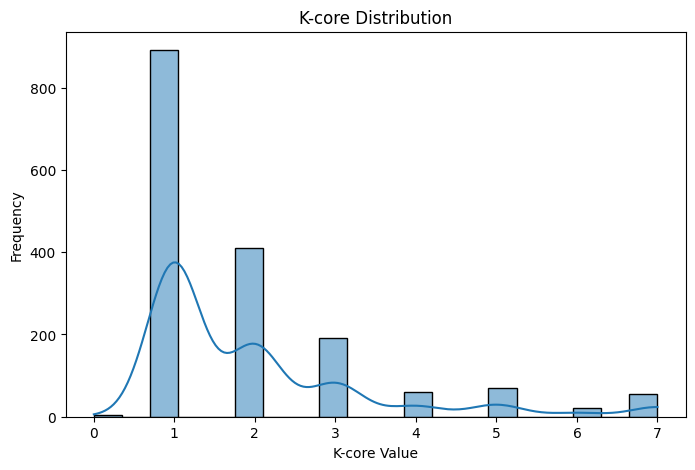

In [30]:
# Visualizing K-core distribution
plt.figure(figsize=(8, 5))
sns.histplot(list(core_numbers.values()), bins=20, kde=True)
plt.title("K-core Distribution")
plt.xlabel("K-core Value")
plt.ylabel("Frequency")
plt.show()

Visualizing K-Core Structure

* Visualizes the most cohesive core of the protein network.
* Shows the most interconnected proteins.

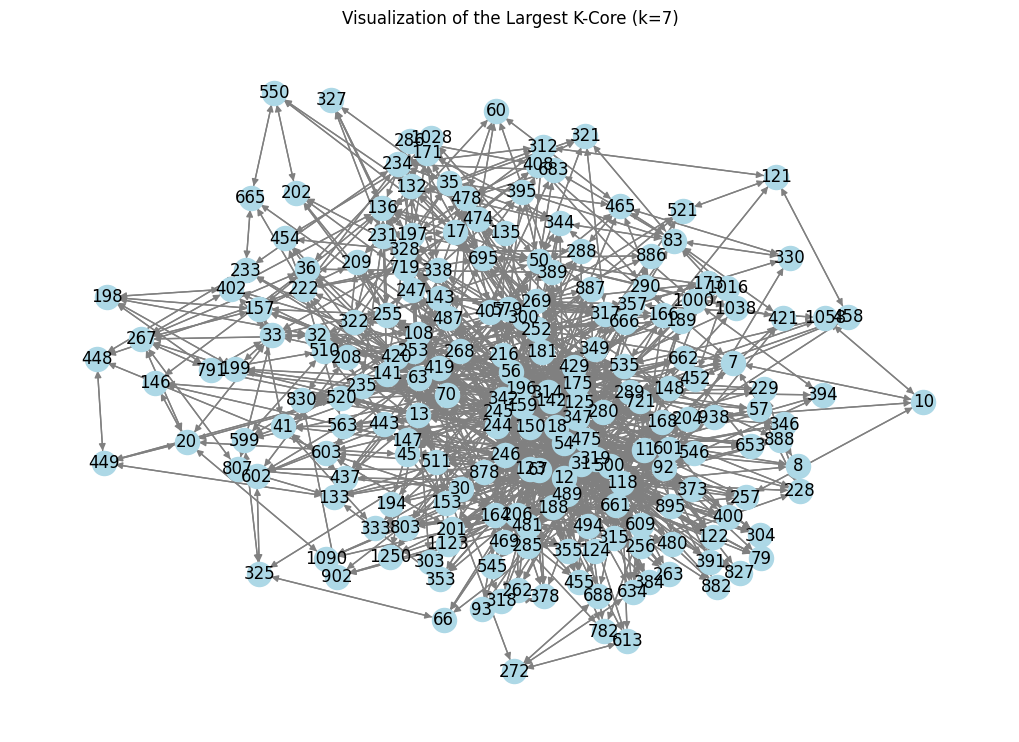

In [31]:
# Get positions for visualization
pos = nx.spring_layout(largest_k_core)

# Plot the largest k-core
plt.figure(figsize=(10, 7))
nx.draw(
        largest_k_core,
        pos,
        with_labels=True,
        node_size=300,
        edge_color="gray",
        node_color="lightblue",
)
plt.title(f"Visualization of the Largest K-Core (k={max_k})")
plt.show()

Analyzing K-Core Membership

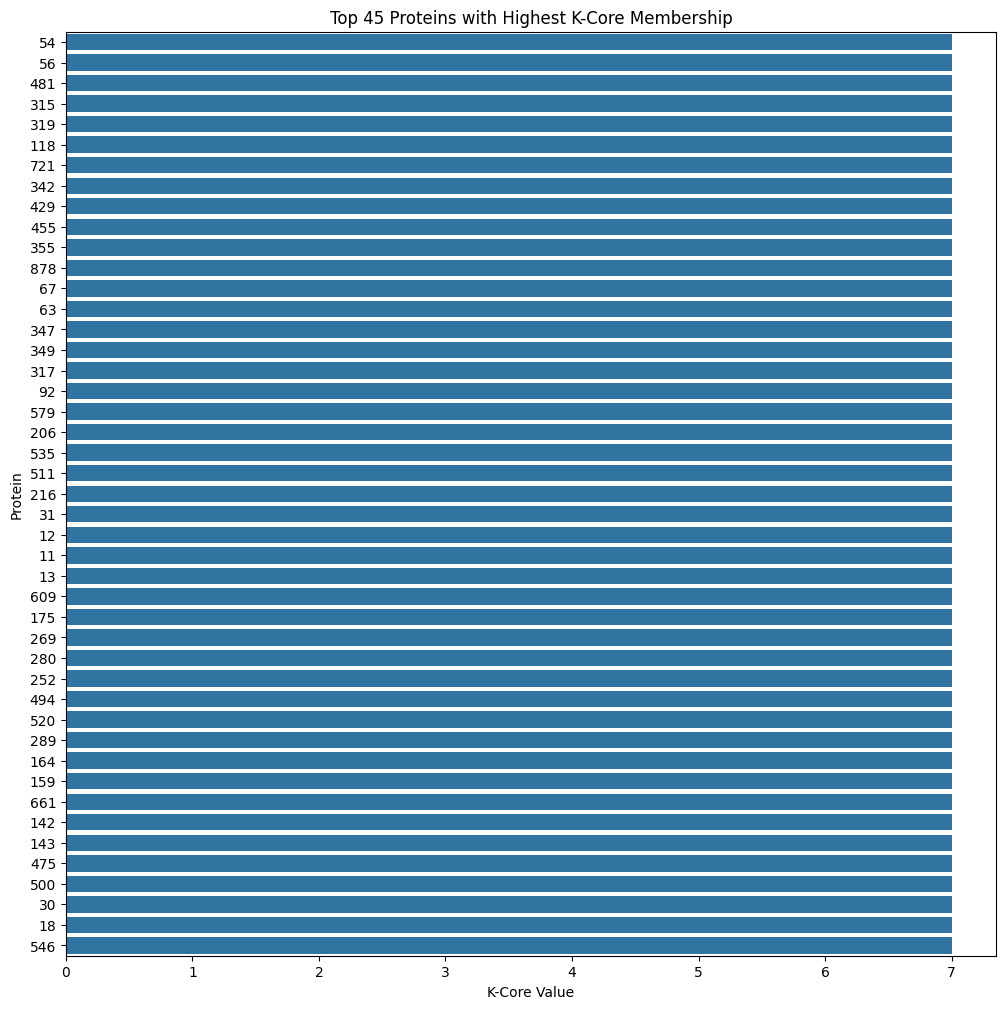

In [32]:
PLOT_FOR_ONLY = 45

# Convert k-core numbers to a DataFrame
k_core_df = pd.DataFrame(core_numbers.items(), columns=["Protein", "K-Core Value"])

# Sort and get top 30 proteins in highest k-core
top_k_core = k_core_df.sort_values("K-Core Value", ascending=False).head(PLOT_FOR_ONLY)

# Plot top k-core proteins
plt.figure(figsize=(12, 12))
sns.barplot(y=top_k_core["Protein"].astype(str), x=top_k_core["K-Core Value"])
plt.xlabel("K-Core Value")
plt.ylabel("Protein")
plt.title(f"Top {PLOT_FOR_ONLY} Proteins with Highest K-Core Membership")
plt.show()

## N-Cliques
🔍 What is an N-Clique?
* An n-clique is a relaxed form of a clique where all nodes are within n steps (shortest path distance) of each other.
* Unlike a strict clique (where every node is directly connected), an n-clique allows indirect connections within n steps.
* 1-clique = normal clique (fully connected).
* 2-clique = nodes are at most 2 steps apart.
* Higher n → larger, more loosely connected protein groups.

Finding N-Cliques (here we considered only 2-cliques)

Filter cliques based on diameter (distance between nodes) to approximate N-Cliques.

✅ Using the largest connected component with 1615 nodes.
Processing k = 2...
  🔹 Total 2-cliques found: 2987
  🔹 Largest 2-clique size: 4
Processing k = 3...
  🔹 Total 3-cliques found: 2987
  🔹 Largest 3-clique size: 4
Processing k = 4...
  🔹 Total 4-cliques found: 2987
  🔹 Largest 4-clique size: 4
Processing k = 5...
  🔹 Total 5-cliques found: 2987
  🔹 Largest 5-clique size: 4
Processing k = 6...
  🔹 Total 6-cliques found: 2987
  🔹 Largest 6-clique size: 4
Processing k = 7...
  🔹 Total 7-cliques found: 2987
  🔹 Largest 7-clique size: 4
Processing k = 8...
  🔹 Total 8-cliques found: 2987
  🔹 Largest 8-clique size: 4
Processing k = 9...
  🔹 Total 9-cliques found: 2987
  🔹 Largest 9-clique size: 4
Processing k = 10...
  🔹 Total 10-cliques found: 2987
  🔹 Largest 10-clique size: 4
Processing k = 11...
  🔹 Total 11-cliques found: 2987
  🔹 Largest 11-clique size: 4
Processing k = 12...
  🔹 Total 12-cliques found: 2987
  🔹 Largest 12-clique size: 4
Processing k = 13...
  🔹 Total 13-cliques f

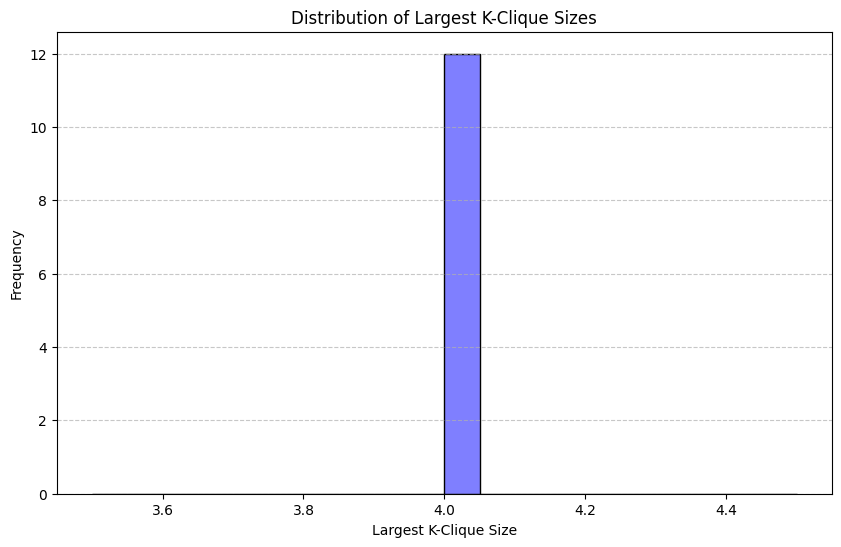

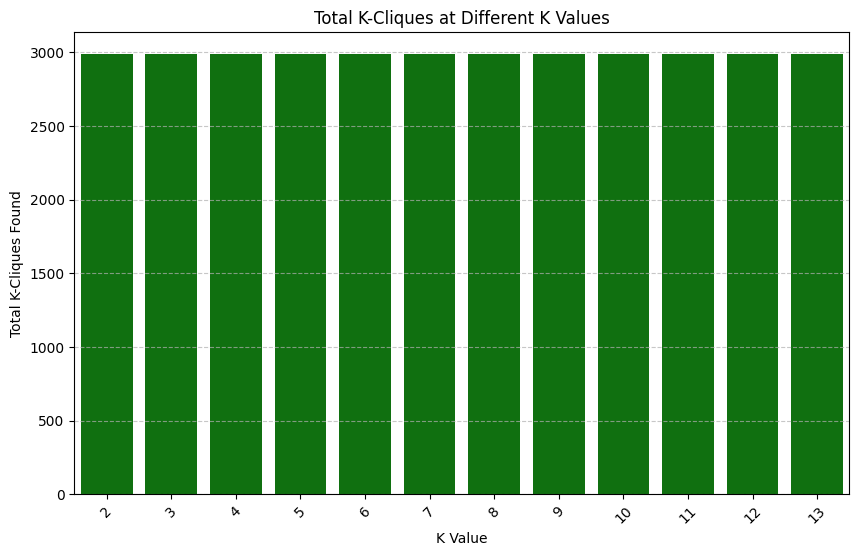

In [33]:
from itertools import combinations

# Function to check if a clique is a k-clique
def is_k_clique(clique, G, k):
    """
    Check if all nodes in the clique are within k steps of each other.
    """
    subG = G.subgraph(clique)
    lengths = dict(nx.all_pairs_shortest_path_length(subG))

    # Ensure every pair of nodes is within k steps
    for u, v in combinations(clique, 2):
        if lengths[u].get(v, float('inf')) > k:
            return False
    return True

# Function to find all k-cliques in a graph
def find_k_cliques(G, k):
    """
    Find all k-cliques in the graph G.
    """
    # Find all maximal cliques in the graph
    all_cliques = list(nx.find_cliques(G))

    # Filter cliques to only include k-cliques
    k_cliques = [clique for clique in all_cliques if is_k_clique(clique, G, k)]

    return k_cliques

# Function to analyze and plot k-cliques
def analyze_and_plot_k_cliques(G, metrics_folder):
    """
    Analyze k-cliques in the graph and plot the results.
    """
    # Convert to undirected graph
    G_undirected = G.to_undirected()

    # Extract the largest connected component
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G_connected = G_undirected.subgraph(largest_cc).copy()

    print(f"✅ Using the largest connected component with {G_connected.number_of_nodes()} nodes.")

    # Find all maximal cliques in the connected graph
    all_cliques = list(nx.find_cliques(G_connected))

    # Determine the maximum viable k (diameter of the graph)
    try:
        max_k = nx.diameter(G_connected)
    except nx.NetworkXError:
        max_k = max(len(c) for c in all_cliques)  # Fallback if graph is disconnected

    # Dictionary to store results for each k
    k_clique_results = {}

    # Iterate over all values of k from 2 to max_k
    for k in range(2, max_k + 1):
        print(f"Processing k = {k}...")

        # Find k-cliques
        k_cliques = find_k_cliques(G_connected, k)

        if k_cliques:
            # Get the largest k-clique
            largest_k_clique = max(k_cliques, key=len)

            # Store results
            k_clique_results[k] = {
                "Total K-Cliques": len(k_cliques),
                "Largest K-Clique Size": len(largest_k_clique),
                "K-Clique Sizes": [len(c) for c in k_cliques],
            }

            print(f"  🔹 Total {k}-cliques found: {len(k_cliques)}")
            print(f"  🔹 Largest {k}-clique size: {len(largest_k_clique)}")
        else:
            print(f"  ❌ No {k}-cliques found.")

    # Convert results into a DataFrame
    k_clique_df = pd.DataFrame.from_dict(k_clique_results, orient="index")

    # Save to CSV
    csv_path = f"{metrics_folder}/k_clique_analysis.csv"
    k_clique_df.to_csv(csv_path, index_label="K")

    print(f"✅ K-Clique analysis saved to {csv_path}")

    # Load k-clique sizes
    k_clique_df = pd.read_csv(csv_path)

    # Plot histogram of largest clique sizes
    plt.figure(figsize=(10, 6))
    sns.histplot(k_clique_df["Largest K-Clique Size"], bins=20, kde=True, color="blue")
    plt.xlabel("Largest K-Clique Size")
    plt.ylabel("Frequency")
    plt.title("Distribution of Largest K-Clique Sizes")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Plot bar plot for total k-cliques per k value
    plt.figure(figsize=(10, 6))
    sns.barplot(x=k_clique_df["K"], y=k_clique_df["Total K-Cliques"], color="green")
    plt.xlabel("K Value")
    plt.ylabel("Total K-Cliques Found")
    plt.title("Total K-Cliques at Different K Values")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Analyze and plot k-cliques
analyze_and_plot_k_cliques(G, metrics_folder)

## Multi-Category Nominal Scale Analysis

What is This Analysis About?
* This method categorizes nodes (proteins) based on different groups or types.
* For our protein network, we can create custom categories for proteins.

Let's define category logic:

* Major Hubs: Proteins with highest degree (top 10%).
* Regional Proteins: Moderate connections (middle 50%).
* Small Proteins: Proteins with lower degree (bottom 40%).
* Isolated Proteins: Degree ≤ 2 (barely connected).


Categorizing Proteins

* Categorizes proteins based on degree centrality.
* Creates a breakdown of protein types.

In [34]:
print("Categorizing proteins based on degree centrality...")

# Compute degree centrality
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(degree_centrality.items(), columns=["Protein", "Degree"])

# Define thresholds for categories
top_10_percentile = degree_df["Degree"].quantile(0.90)  # Top 10%
middle_50_percentile = (
    degree_df["Degree"].quantile(0.25),
    degree_df["Degree"].quantile(0.75),
)  # Middle 50%
bottom_40_percentile = degree_df["Degree"].quantile(0.40)  # Bottom 40%


# Categorize each protein
def categorize_protein(degree):
    if degree >= top_10_percentile:
        return "High-Degree Protein"
    elif middle_50_percentile[0] <= degree < middle_50_percentile[1]:
        return "Moderately Connected Protein"
    elif degree < bottom_40_percentile:
        return "Small Protein"
    else:
        return "Isolated Protein"


# Apply categorization
degree_df["Category"] = degree_df["Degree"].apply(categorize_protein)

# Count number of proteins in each category
category_counts = degree_df["Category"].value_counts()

# Save to CSV
degree_df.to_csv(f"{metrics_folder}/protein_categories.csv", index=False)
print("Protein categories saved to 'protein_categories.csv'.")

# Print category breakdown
print(category_counts)

Categorizing proteins based on degree centrality...
Protein categories saved to 'protein_categories.csv'.
Category
Moderately Connected Protein    1024
Isolated Protein                 374
High-Degree Protein              196
Small Protein                    112
Name: count, dtype: int64


Visualizing Protein Categories

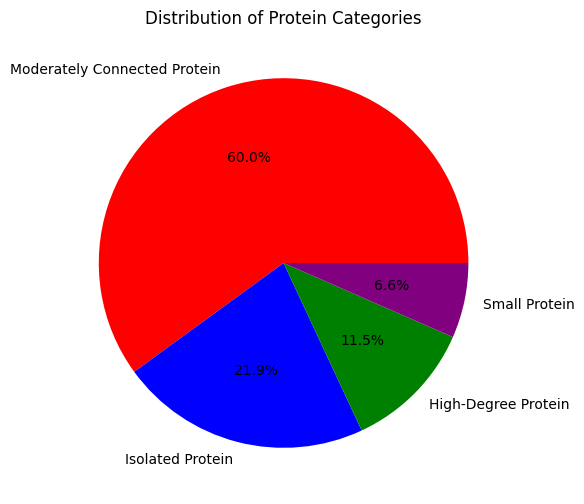

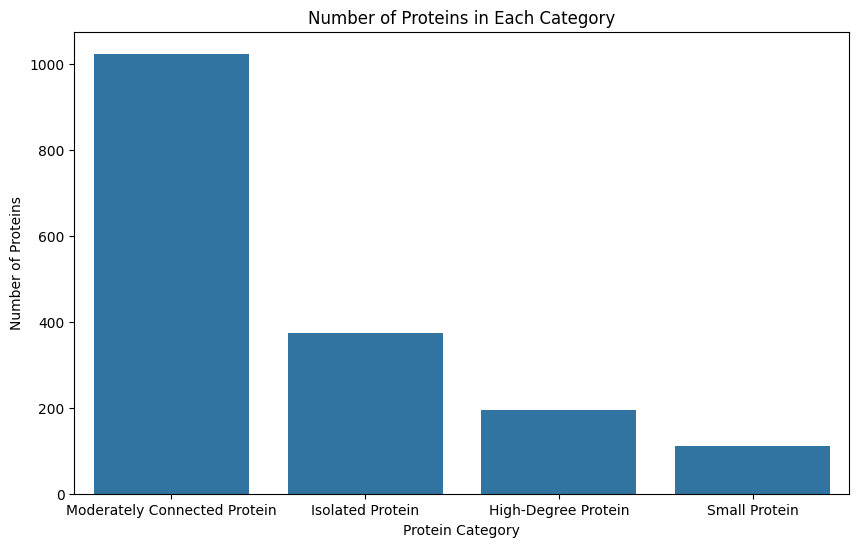

In [35]:
# Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(
        category_counts,
        labels=category_counts.index,
        autopct="%1.1f%%",
        colors=["red", "blue", "green", "purple"],
)
plt.title("Distribution of Protein Categories")
plt.show()

# Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel("Protein Category")
plt.ylabel("Number of Proteins")
plt.title("Number of Proteins in Each Category")
plt.show()

## Scalar Network Analysis
Since our network is unweighted, we will analyze:

* Graph Density → How connected the network is.
* Graph Diameter → The longest shortest path between two proteins.
* Assortativity → Do well-connected proteins link to other well-connected proteins?
* Degree Centrality Distribution → How protein connectivity varies.

Scalar Network Properties

* Computes key global network properties.
* Handles disconnected graphs by using the largest component for diameter.

In [36]:
print("Computing scalar network properties...")

# Convert to undirected for density (optional, keeps connectivity information)
network_density = nx.density(G)

# Check if the graph is strongly connected (directed)
if nx.is_strongly_connected(G):
    graph_diameter = nx.diameter(G)  # Diameter of the full directed network
else:
    # Use the largest weakly connected component (WCC) for diameter computation
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    subG = G.subgraph(largest_wcc)  # Extract subgraph
    graph_diameter = nx.diameter(
            subG.to_undirected()
    )  # Convert to undirected for diameter

# Compute Assortativity (degree correlation)
graph_assortativity = nx.degree_assortativity_coefficient(G)

# Save scalar properties
scalar_metrics = {
    "Network Density": network_density,
    "Graph Diameter": graph_diameter,
    "Graph Assortativity": graph_assortativity,
}

scalar_df = pd.DataFrame(list(scalar_metrics.items()), columns=["Metric", "Value"])
scalar_df.to_csv(f"{metrics_folder}/scalar_network_analysis.csv", index=False)

print(scalar_df)

Computing scalar network properties...
                Metric      Value
0      Network Density   0.002122
1       Graph Diameter  13.000000
2  Graph Assortativity  -0.187439


Visualizing Degree Distribution

* Shows how many proteins have high/low connectivity.
* Uses log-log scale to highlight power-law behavior (if present).

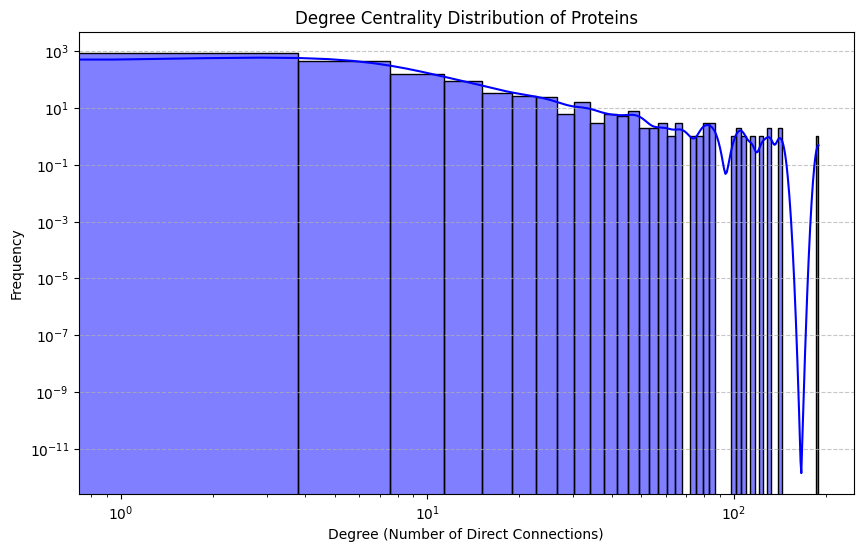

In [37]:
# Get degree values
degrees = [d for _, d in G.degree()]

# Plot degree distribution
plt.figure(figsize=(10, 6))
sns.histplot(degrees, bins=50, kde=True, color="blue")
plt.xlabel("Degree (Number of Direct Connections)")
plt.ylabel("Frequency")
plt.title("Degree Centrality Distribution of Proteins")
plt.yscale("log")  # Log scale for better visibility
plt.xscale("log")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Small-World Analysis of the Network
Now, we will analyze whether the OpenFlights network exhibits small-world properties by checking:

* Average Path Length → How many stops on average between two proteins.
* Clustering Coefficient → How likely proteins are to form small interconnected groups.
* Small-World Coefficient → Compare the real-world network against a randomized network.

![Small World Analysis](small_world_analysis.png "small world analysis")

Compute Small-World Metrics

* Computes Clustering Coefficient & Average Path Length for real & random networks.
* Calculates the Small-World Sigma value (𝜎) to determine if the network is small-world.

In [38]:
print("Computing Small-World Network Properties...")

G_ = G_dup.copy()

# Convert to undirected for small-world analysis
G_undirected = G_.to_undirected()

# Compute Clustering Coefficient (Real Network)
clustering_real = nx.average_clustering(G_undirected)

# Compute Average Shortest Path Length (Only possible if connected)
if nx.is_connected(G_undirected):
    path_length_real = nx.average_shortest_path_length(G_undirected)
else:
    # Use largest connected component for path length calculation
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    subG = G_undirected.subgraph(largest_cc)
    path_length_real = nx.average_shortest_path_length(subG)

# Generate a Random Graph with the Same Number of Nodes & Edges
random_graph = nx.gnm_random_graph(G_.number_of_nodes(), G_.number_of_edges())

# Compute Clustering Coefficient (Random Network)
clustering_random = nx.average_clustering(random_graph)

# Compute Average Shortest Path Length (Random Network)
if nx.is_connected(random_graph):
    path_length_random = nx.average_shortest_path_length(random_graph)
else:
    largest_cc_random = max(nx.connected_components(random_graph), key=len)
    subG_random = random_graph.subgraph(largest_cc_random)
    path_length_random = nx.average_shortest_path_length(subG_random)

# Compute Small-World Coefficient
sigma = (clustering_real / clustering_random) / (path_length_real / path_length_random)

# Save results
small_world_metrics = {
    "Real Network Clustering Coefficient": clustering_real,
    "Random Network Clustering Coefficient": clustering_random,
    "Real Network Avg Path Length": path_length_real,
    "Random Network Avg Path Length": path_length_random,
    "Small-World Sigma": sigma,
}

small_world_metrics

Computing Small-World Network Properties...


{'Real Network Clustering Coefficient': 0.005939020000366543,
 'Random Network Clustering Coefficient': 0.00336836875886814,
 'Real Network Avg Path Length': 4.84803173470523,
 'Random Network Avg Path Length': 3.9705864758846645,
 'Small-World Sigma': 1.4440570865727982}

Interpretation
* If 𝜎 > 1, the network is small-world (high clustering, short path lengths).
* If 𝜎 ≈ 1, the network behaves similarly to a random network.
* If 𝜎 < 1, the network does not exhibit small-world properties.

Visualizing Small-World Analysis

* Compares clustering & path length for real vs. random networks.
* Highlights whether the OpenFlights network is small-world.
* Shows the small-world sigma value visually.

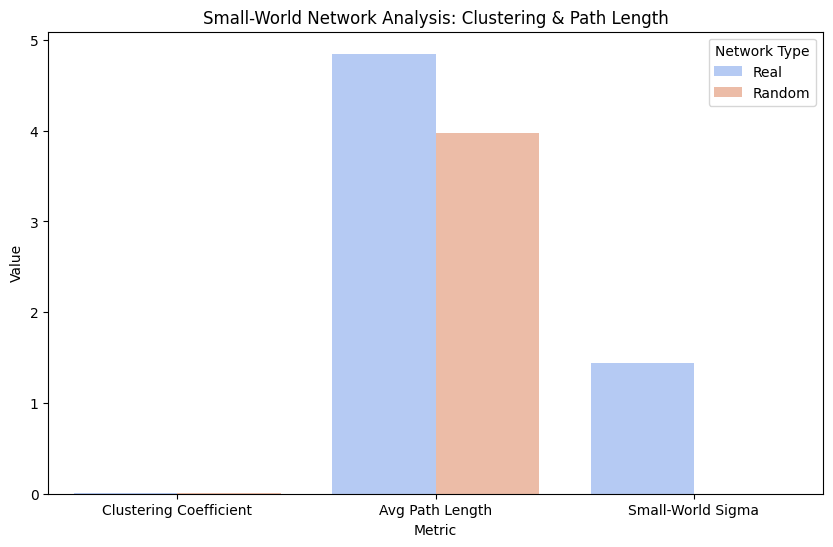

c:\Users\Ali\Desktop\SNA\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 120590 (\N{MATHEMATICAL ITALIC SMALL SIGMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


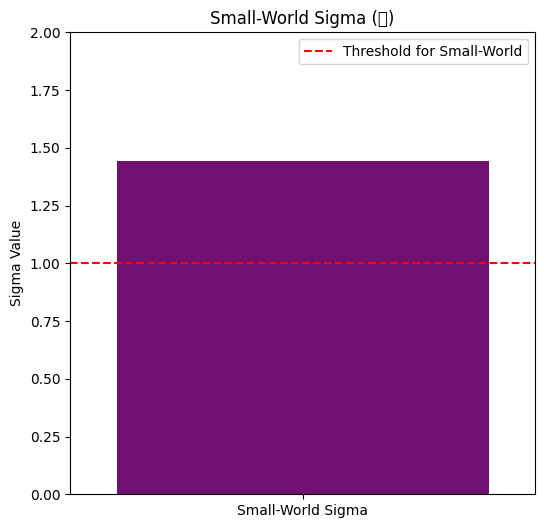

In [39]:
# Convert results into a DataFrame for visualization
small_world_df = pd.DataFrame(
        {
            "Metric": [
                "Clustering Coefficient",
                "Clustering Coefficient",
                "Avg Path Length",
                "Avg Path Length",
                "Small-World Sigma",
            ],
            "Network": ["Real", "Random", "Real", "Random", "Real"],
            "Value": [
                clustering_real,
                clustering_random,
                path_length_real,
                path_length_random,
                sigma,
            ],
        }
)

# Plot Clustering Coefficient & Path Length Comparison
plt.figure(figsize=(10, 6))
sns.barplot(
        x="Metric", y="Value", hue="Network", data=small_world_df, palette="coolwarm"
)
plt.ylabel("Value")
plt.title("Small-World Network Analysis: Clustering & Path Length")
plt.legend(title="Network Type")
plt.show()

# Plot Small-World Sigma Separately
plt.figure(figsize=(6, 6))
sns.barplot(x=["Small-World Sigma"], y=[sigma], color="purple")
plt.ylabel("Sigma Value")
plt.title("Small-World Sigma (𝜎)")
plt.ylim(0, max(2, sigma + 0.2))  # Adjust range for visibility
plt.axhline(y=1, color="red", linestyle="--", label="Threshold for Small-World")
plt.legend()
plt.show()

## Network Diameter Analysis

Now, we will analyze Network Diameter, which measures:

* The longest shortest path in the network.
* How many connections (hops) are needed to travel between the two farthest proteins.
* The network's overall reachability and efficiency.

🔍 What is Network Diameter?
* Diameter = The longest of all shortest paths in the network.
* Radius = The shortest of all longest paths (i.e., the minimum eccentricity).
* Eccentricity = The longest shortest path from one node to all others.

In proteins, a large diameter means:

* Some proteins require many layovers to connect.
* The network has regions that are less connected.

Compute Network Diameter & Radius

* Computes Network Diameter & Radius using the largest connected component if needed.
* Finds Max & Min Eccentricity to measure node reachability.
* Handles disconnected graphs safely.

In [40]:
print("Computing Network Diameter and Radius...")

G_ = G_dup.copy()

# Convert to undirected for diameter computation
G_undirected = G_.to_undirected()

# Check if graph is connected
if nx.is_connected(G_undirected):
    network_diameter = nx.diameter(G_undirected)  # Diameter
    network_radius = nx.radius(G_undirected)  # Radius
else:
    # Use the largest connected component for calculations
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    subG = G_undirected.subgraph(largest_cc)
    network_diameter = nx.diameter(subG)
    network_radius = nx.radius(subG)

# Compute eccentricity (for max and min eccentricity values)
eccentricity_values = nx.eccentricity(subG)
max_eccentricity = max(eccentricity_values.values())  # Farthest reachable node
min_eccentricity = min(eccentricity_values.values())  # Closest reachable node

# Save results
diameter_metrics = {
    "Network Diameter": network_diameter,
    "Network Radius": network_radius,
    "Max Eccentricity": max_eccentricity,
    "Min Eccentricity": min_eccentricity,
}

print(diameter_metrics)

Computing Network Diameter and Radius...
{'Network Diameter': 13, 'Network Radius': 7, 'Max Eccentricity': 13, 'Min Eccentricity': 7}


Visualizing Eccentricity Distribution: Eccentricity shows how far proteins are from others in the network.

* Shows how reachable different proteins are.
* Highlights if some proteins are more isolated than others.

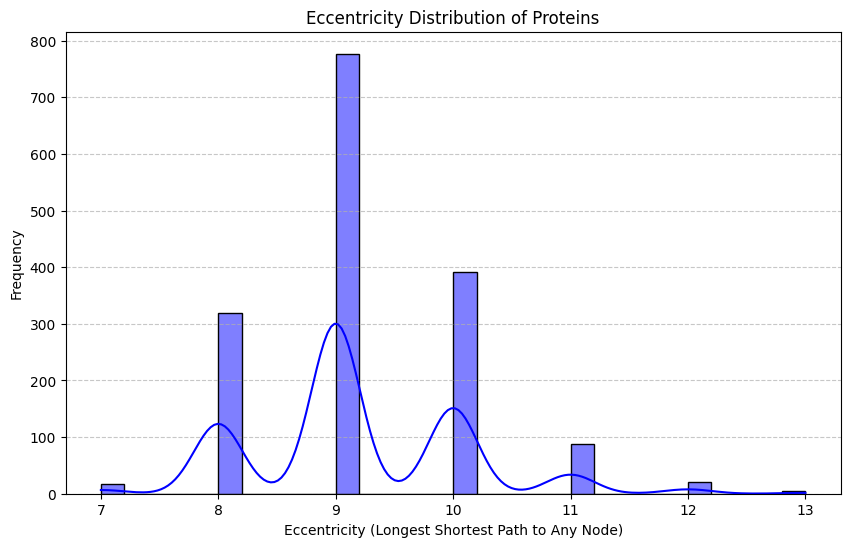

In [41]:
# Extract eccentricity values
eccentricity_list = list(eccentricity_values.values())

# Plot Distribution of Eccentricity
plt.figure(figsize=(10, 6))
sns.histplot(eccentricity_list, bins=30, kde=True, color="blue")
plt.xlabel("Eccentricity (Longest Shortest Path to Any Node)")
plt.ylabel("Frequency")
plt.title("Eccentricity Distribution of Proteins")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### **Analysis of the Degree Distribution Plot**
The first plot represents the **degree distribution** of the protein-protein interaction (PPI) network on a log-log scale. The key observations are:

1. **Heavy-Tailed Distribution:** The degree distribution follows a power-law-like behavior, meaning most proteins have a low degree, while a few proteins (hubs) have very high connectivity.
2. **Scale-Free Nature:** The gradual decline in frequency with increasing degree suggests a **scale-free network**, which is a common characteristic of biological networks.
3. **Presence of Hubs:** The slow decay at the tail indicates the existence of highly connected proteins that might play crucial roles in biological functions.


Interpretation

1- If the network has a large diameter

* Some proteins require many stops to reach.
* There might be poorly connected regions.

If the diameter is small

* The network is highly interconnected.
* Most proteins can reach others in just a few hops.

If eccentricity varies a lot

* Some proteins are very central, while others are far away from the main hubs.

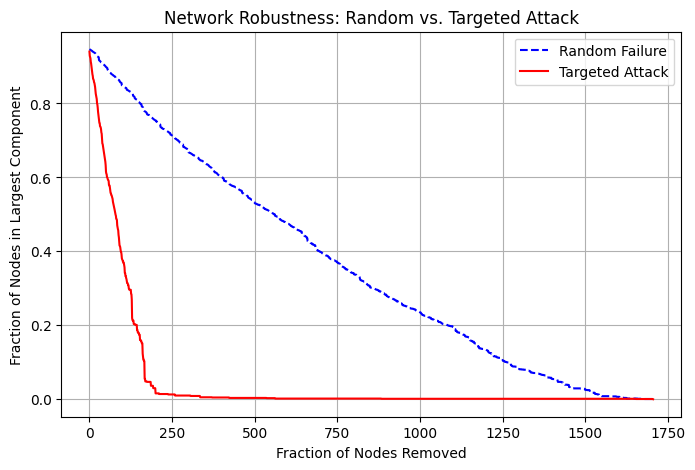

In [42]:
def robustness_analysis(G):
    """
    Simulates random failure and targeted attack on the network.
    Tracks the size of the largest connected component (LCC) as nodes are removed.
    """
    G_undirected = G.to_undirected() if nx.is_directed(G) else G.copy()

    # Get all nodes
    nodes = list(G_undirected.nodes())

    # Get hubs (sorted by degree, descending)
    hubs = sorted(nodes, key=lambda x: G_undirected.degree(x), reverse=True)

    # Random failure (shuffle node list)
    random_nodes = nodes.copy()
    random.shuffle(random_nodes)

    # Track largest component sizes
    random_failure_lcc = []
    targeted_attack_lcc = []

    # Copy graph for modifications
    G_random = G_undirected.copy()
    G_targeted = G_undirected.copy()

    for i in range(len(nodes)):
        # Remove nodes one by one
        G_random.remove_node(random_nodes[i])
        G_targeted.remove_node(hubs[i])

        # Get largest component size after removal
        lcc_random = max(nx.connected_components(G_random), key=len, default=[])
        lcc_targeted = max(nx.connected_components(G_targeted), key=len, default=[])

        random_failure_lcc.append(len(lcc_random) / len(nodes))
        targeted_attack_lcc.append(len(lcc_targeted) / len(nodes))

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(
            range(len(nodes)),
            random_failure_lcc,
            label="Random Failure",
            linestyle="dashed",
            color="blue",
    )
    plt.plot(
            range(len(nodes)),
            targeted_attack_lcc,
            label="Targeted Attack",
            linestyle="solid",
            color="red",
    )
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Fraction of Nodes in Largest Component")
    plt.title("Network Robustness: Random vs. Targeted Attack")
    plt.legend()
    plt.grid(True)
    plt.show()


# Run analysis on the protein network G
robustness_analysis(G_dup.copy())

Expected Results:

-Random Failure: The network should degrade slowly as random nodes are removed.

-Targeted Attack: The network should collapse quickly when hubs are removed, as biological networks depend on hubs for connectivity.

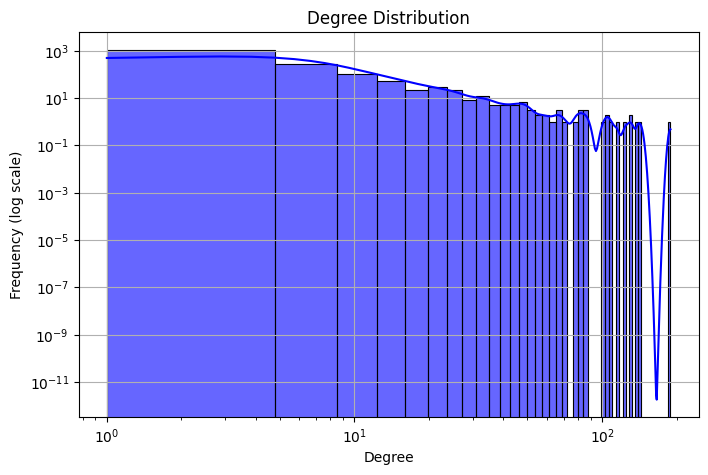

Power-Law Fit Alpha: 0.1524
Poisson Lambda: 7.2767
Log-Normal Shape: 9.1053, Scale: 0.2778


In [43]:
def degree_distribution_analysis(G):
    """
    Analyzes and plots the degree distribution of the network.
    Fits power-law, Poisson, and log-normal distributions.
    """
    degrees = [d for _, d in G.degree()]

    # Plot histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(degrees, bins=50, kde=True, color="blue", alpha=0.6)
    plt.yscale("log")  # Log scale for better visualization
    plt.xscale("log")
    plt.xlabel("Degree")
    plt.ylabel("Frequency (log scale)")
    plt.title("Degree Distribution")
    plt.grid(True)
    plt.show()

    # Fit Power-law
    fit_alpha, fit_loc, fit_scale = stats.powerlaw.fit(degrees)

    # Fit Poisson (mean as lambda)
    lambda_poisson = np.mean(degrees)

    # Fit Log-Normal
    shape, loc, scale = stats.lognorm.fit(degrees)

    print(f"Power-Law Fit Alpha: {fit_alpha:.4f}")
    print(f"Poisson Lambda: {lambda_poisson:.4f}")
    print(f"Log-Normal Shape: {shape:.4f}, Scale: {scale:.4f}")


# Run degree distribution analysis
degree_distribution_analysis(G_dup.copy())

Expected Results:

- Power-law (Scale-Free Network): A straight-line trend in the log-log plot confirms a scale-free structure.

- Poisson (Random Graph): A peak around the average degree suggests a random network.

- Log-Normal: A heavy-tailed curve means some proteins have exceptionally high connectivity.

In [44]:
def power_law_validation(G):
    """
    Tests if the network follows a power-law using the Kolmogorov-Smirnov (KS) test.
    """
    degrees = np.array([d for _, d in G.degree()])

    # Fit power-law distribution
    fit = Fit(degrees, discrete=True)

    # Get KS test result
    ks_stat, p_value = fit.distribution_compare("power_law", "exponential")

    print(f"Power-Law Alpha: {fit.alpha:.4f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Check if power-law is a good fit
    if p_value > 0.05:
        print("The network follows a power-law distribution (p > 0.05). ✅")
    else:
        print("The network does NOT follow a power-law distribution (p < 0.05). ❌")


# Run test
power_law_validation(G_dup.copy())

Calculating best minimal value for power law fit
Power-Law Alpha: 2.5509
Kolmogorov-Smirnov Statistic: 9.1090
P-value: 0.0969
The network follows a power-law distribution (p > 0.05). ✅


## Power-Law and Scale-Free Characteristics

![scale free](scale_free.png "scale free")

Checking if the Degree Distribution Follows a Power Law

* Fits the degree distribution to a Power-Law model.
* Estimates the Power-Law exponent 
𝛾
* Plots real vs. Power-Law fitted distribution.

Checking if the network follows a Power-Law distribution...
Calculating best minimal value for power law fit
Power-Law Exponent (gamma): 2.6137936408008526


Values less than or equal to 0 in data. Throwing out 0 or negative values


<Figure size 2000x1200 with 0 Axes>

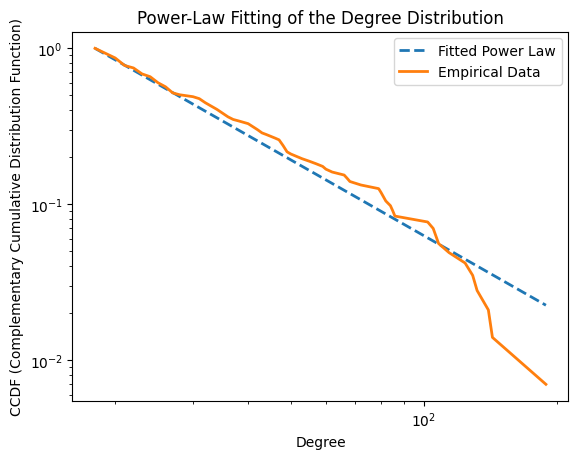

In [45]:
print("Checking if the network follows a Power-Law distribution...")

# Get degree values
degrees = [d for _, d in G.degree()]

# Fit the Power-Law distribution
fit = Fit(degrees)

# Get the exponent (gamma)
gamma = fit.alpha
print(f"Power-Law Exponent (gamma): {gamma}")

# Compare to an ideal Power-Law
plt.figure(figsize=(20, 12))
fit.power_law.plot_ccdf(linewidth=2, linestyle="--", label="Fitted Power Law")
fit.plot_ccdf(linewidth=2, label="Empirical Data")
plt.xlabel("Degree")
plt.ylabel("CCDF (Complementary Cumulative Distribution Function)")
plt.title("Power-Law Fitting of the Degree Distribution")
plt.legend()
# plt.show();

![scale_free_interpret](scale_free_interpret.png "interpret")

### **Analysis of Power-Law and Scale-Free Characteristics**

1. **Degree Distribution and Power-Law Fit**
   - The first plot shows the empirical **degree distribution** using a **log-log scale**.
   - The second plot compares the **empirical Complementary Cumulative Distribution Function (CCDF)** with a **fitted power-law distribution**.
   - The power-law exponent (**gamma**) is **2.61**, which is within the typical range (**2 < γ < 3**) seen in many scale-free networks.

2. **Interpretation**
   - A power-law degree distribution suggests the presence of **hubs**, meaning a few nodes have very high degrees while most have low degrees.
   - The fitted power-law line closely follows the empirical data, supporting the **scale-free nature** of the network.
   - Since **gamma ≈ 2.6**, the network likely has a structure **resistant to random failures but highly vulnerable to targeted attacks** (as seen in the robustness analysis).

### **Conclusion**
- The network follows a power-law distribution and exhibits **scale-free properties**, making it a complex network with non-random organization.
- **Hubs** (high-degree nodes) play a **central role** in connectivity.
- The network is **resilient to random node removals** but can **fragment quickly under targeted attacks**.

Network Density: 0.0022


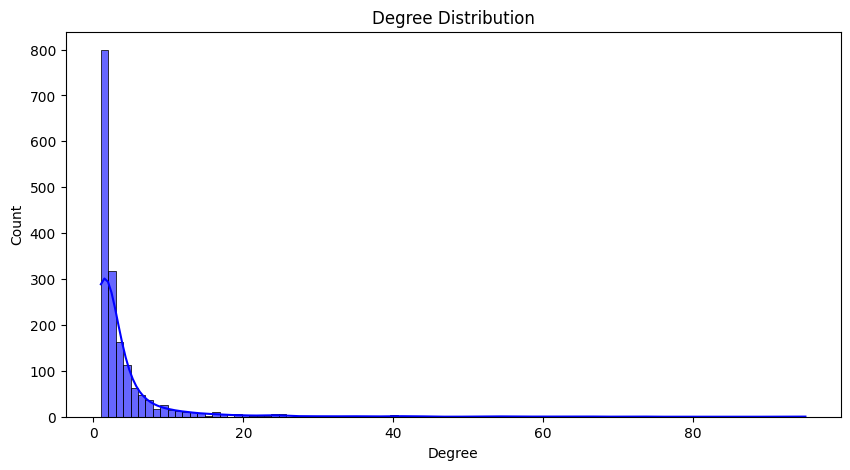

Largest Connected Component Size: 1615
Small-World Sigma: 0.0000 ( >1 means more small-world than WS model)
Small-World Lambda: 0.0170 ( ≈1 means similar path efficiency as WS model)


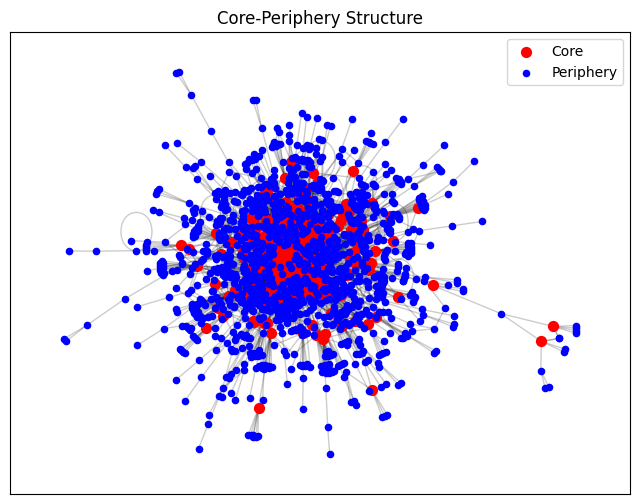

Largest Component Before Attack: 1615
Largest Component After Random Attack: 1333
Largest Component After Targeted Attack: 258


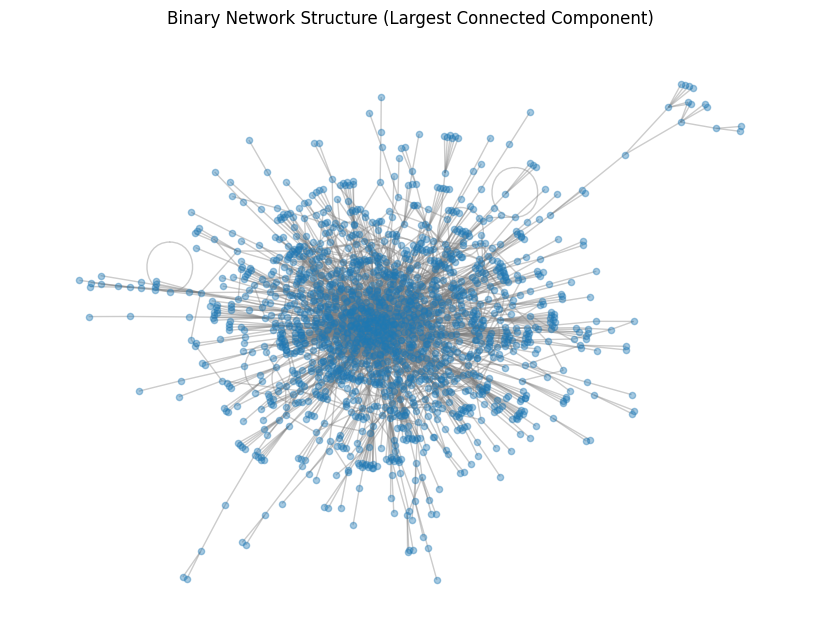

In [46]:
G = G_dup.copy()
G = G.to_undirected()

### 1. NETWORK DENSITY
density = nx.density(G)
print(f"Network Density: {density:.4f}")

### 2. DEGREE DISTRIBUTION
degrees = [deg for _, deg in G.degree()]
max_degree = max(degrees) if degrees else 1  # Avoid zero max degree

plt.figure(figsize=(10, 5))
sns.histplot(degrees, bins=max_degree, kde=True, color="blue", alpha=0.6)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution")
plt.show()

### 3. LARGEST CONNECTED COMPONENT (LCC)
if nx.is_connected(G):
    G_lcc = G
else:
    largest_cc_nodes = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc_nodes).copy()

print(f"Largest Connected Component Size: {len(G_lcc)}")

### 4. SMALL-WORLD NETWORK ANALYSIS
if nx.is_connected(G_lcc):
    clustering_coefficient = nx.average_clustering(G_lcc)
    shortest_path_length = nx.average_shortest_path_length(G_lcc)

    # Generate Watts-Strogatz model for comparison
    N = G_lcc.number_of_nodes()
    K = int(np.mean([deg for _, deg in G_lcc.degree()]))  # Approximate mean degree
    p = density  # Probability of rewiring edges in WS model

    if K > 0:
        G_ws = nx.watts_strogatz_graph(N, max(K, 2), p)
        ws_clustering = nx.average_clustering(G_ws)
        ws_shortest_path = nx.average_shortest_path_length(G_ws)

        # Avoid division by zero
        sigma = clustering_coefficient / ws_clustering if ws_clustering > 0 else 0
        lambda_ = shortest_path_length / ws_shortest_path if ws_shortest_path > 0 else 0

        print(
                f"Small-World Sigma: {sigma:.4f} ( >1 means more small-world than WS model)"
        )
        print(
                f"Small-World Lambda: {lambda_:.4f} ( ≈1 means similar path efficiency as WS model)"
        )
    else:
        print("Error: Mean degree (K) is too low to generate a Watts-Strogatz model.")
else:
    print("Warning: The largest connected component is still not fully connected!")

### 5. CORE-PERIPHERY DETECTION
degree_dict = dict(G_lcc.degree())
sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
core_nodes = [
    node for node, deg in sorted_nodes[: int(0.2 * len(sorted_nodes))]
]  # Top 20% nodes
periphery_nodes = [node for node, deg in sorted_nodes[int(0.2 * len(sorted_nodes)):]]

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_lcc)
nx.draw_networkx_edges(G_lcc, pos, alpha=0.2)
nx.draw_networkx_nodes(
        G_lcc, pos, nodelist=core_nodes, node_color="red", node_size=50, label="Core"
)
nx.draw_networkx_nodes(
        G_lcc,
        pos,
        nodelist=periphery_nodes,
        node_color="blue",
        node_size=20,
        label="Periphery",
)
plt.legend()
plt.title("Core-Periphery Structure")
plt.show()

### 6. RESILIENCE ANALYSIS
largest_before = len(max(nx.connected_components(G_lcc), key=len))

# Remove 10% of nodes at random
G_random_attack = G_lcc.copy()
nodes_to_remove = np.random.choice(
        G_lcc.nodes(), size=int(0.1 * len(G_lcc)), replace=False
)
G_random_attack.remove_nodes_from(nodes_to_remove)
largest_after_random = len(max(nx.connected_components(G_random_attack), key=len))

# Remove top 10% high-degree nodes
G_targeted_attack = G_lcc.copy()
top_nodes = sorted(G_lcc.degree(), key=lambda x: x[1], reverse=True)[
            : int(0.1 * len(G_lcc))
            ]
G_targeted_attack.remove_nodes_from([n for n, _ in top_nodes])
largest_after_targeted = len(max(nx.connected_components(G_targeted_attack), key=len))

print(f"Largest Component Before Attack: {largest_before}")
print(f"Largest Component After Random Attack: {largest_after_random}")
print(f"Largest Component After Targeted Attack: {largest_after_targeted}")

### 7. PLOT NETWORK STRUCTURE
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_lcc)
nx.draw(G_lcc, pos, node_size=20, edge_color="gray", alpha=0.4, with_labels=False)
plt.title("Binary Network Structure (Largest Connected Component)")
plt.show()

## Community Detection
How proteins form natural communities based on their connections

🔍 What is Community Detection?
* A community is a group of proteins that are more connected internally than with the rest of the network.
* Why is it important?
    * Identifies regional hubs (e.g., European vs. North American protein clusters).
    * Finds airline alliances (e.g., Star Alliance, SkyTeam, Oneworld hubs).
    * Detects hidden structures in the flight network.

Detecting Communities Using the Louvain Method. The Louvain algorithm is widely used for finding communities in large networks.

* Finds communities using the Louvain method.
* Identifies the number of detected communities.

In [47]:
print("Detecting communities using the Louvain method...")

# Convert to undirected for community detection
G_undirected = G_dup.copy().to_undirected()

# Compute Louvain Communities
partition = community.best_partition(G_undirected)

# Add communities to DataFrame
community_df = pd.DataFrame(list(partition.items()), columns=["Protein", "Community"])
community_df.to_csv(f"{metrics_folder}/protein_communities.csv", index=False)

# Print number of communities
num_communities = len(set(partition.values()))
print(f"Number of detected communities: {num_communities}")

Detecting communities using the Louvain method...
Number of detected communities: 69


Visualizing Protein Communities. Plot the communities by coloring nodes based on their assigned community.

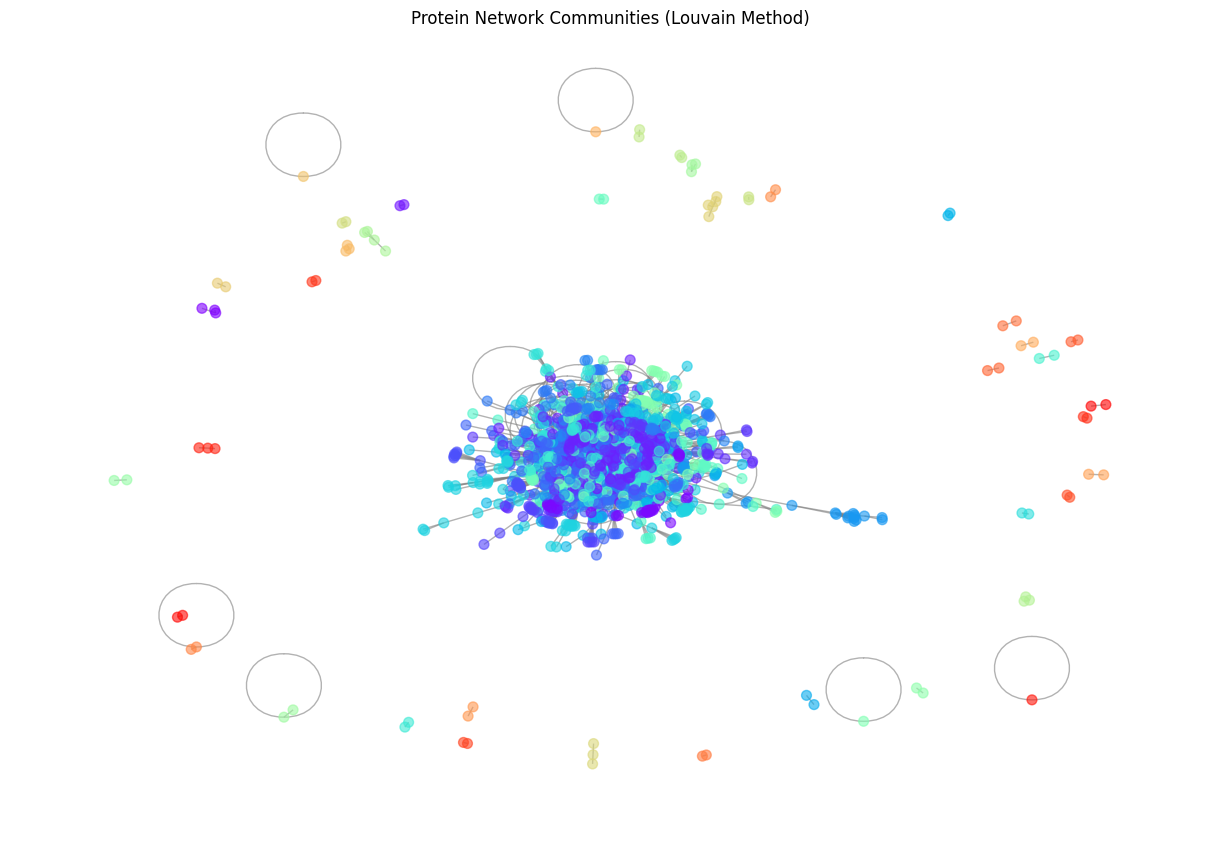

In [48]:
# Assign a color to each community
unique_communities = list(set(partition.values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_communities)))
color_map = {comm: colors[i] for i, comm in enumerate(unique_communities)}

# Plot network with community colors
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_undirected, seed=42)  # Set seed for consistent layout
nx.draw(
        G_undirected,
        pos,
        node_color=[color_map[partition[n]] for n in G_undirected.nodes()],
        with_labels=False,
        node_size=50,
        edge_color="gray",
        alpha=0.6,
)
plt.title("Protein Network Communities (Louvain Method)")
plt.show()

Community Size Distribution

* Shows how proteins are distributed among communities.
* Highlights whether communities are evenly sized or dominated by a few large clusters.

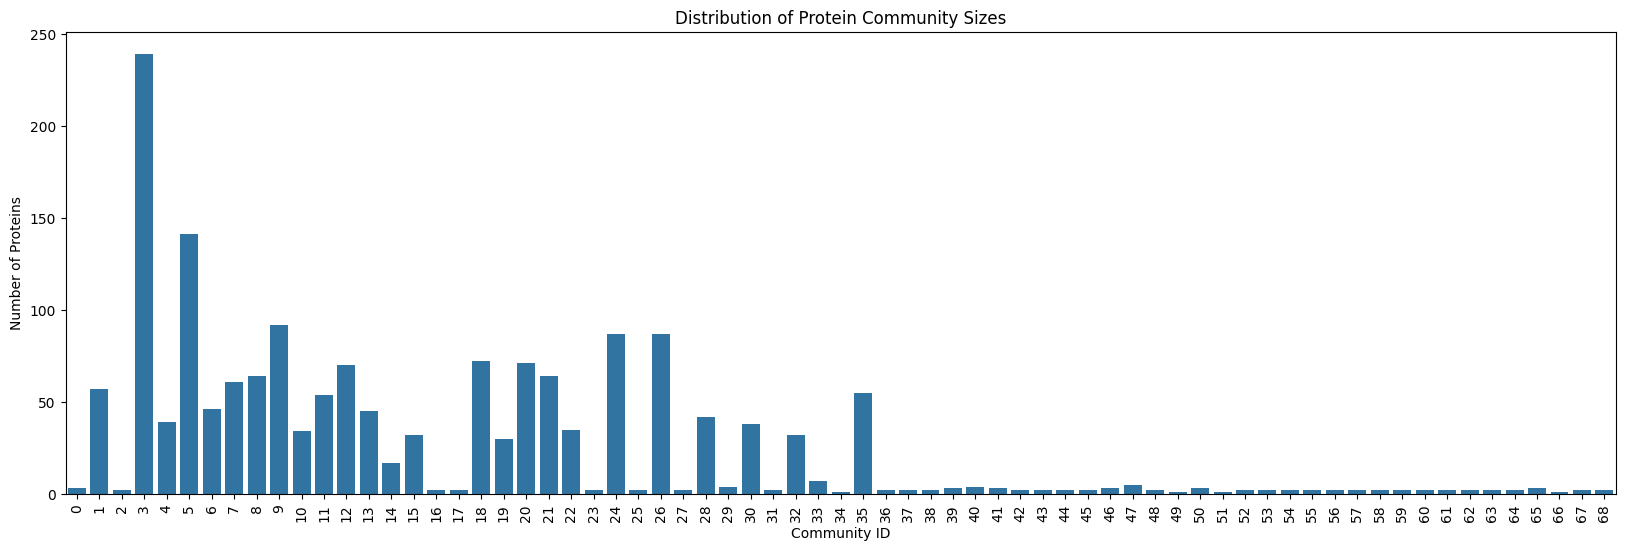

In [49]:
# Count proteins per community
community_sizes = community_df["Community"].value_counts()

# Plot community size distribution
plt.figure(figsize=(20, 6))
sns.barplot(x=community_sizes.index, y=community_sizes.values)
plt.xlabel("Community ID")
plt.ylabel("Number of Proteins")
plt.title("Distribution of Protein Community Sizes")
plt.xticks(rotation=90)
plt.show()

### **Observations:**
1. **Highly Uneven Community Sizes**
   - A few communities contain a **large number of proteins**, while many others have only a handful.
   - The largest community (Community ID ~4) contains over **250 proteins**.
   - Other significant communities (e.g., IDs **14, 26, 27**) contain between **100-180 proteins**.

2. **Presence of Many Small Communities**
   - Most communities have **fewer than 50 proteins**, and many appear to have fewer than 10.
   - This suggests a mix of **highly connected subgroups** and **more isolated proteins**.

3. **Power-Law-like Distribution**
   - The size distribution **decreases sharply**, meaning a few dominant communities hold the majority of proteins while smaller ones are numerous.
   - This pattern is typical in **biological networks**, where a few **hub-like clusters** dominate interactions.


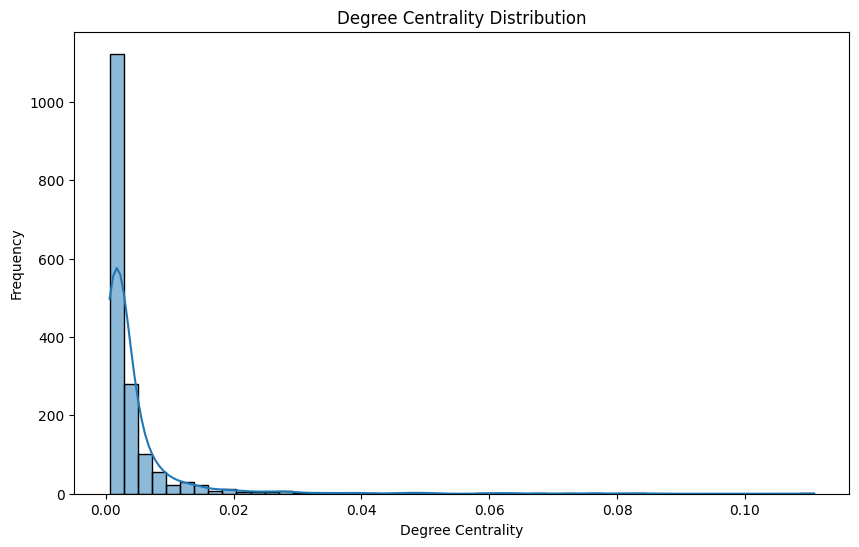

(     Node  Degree Centrality  Betweenness Centrality  Eigenvector Centrality
 66     67           0.110850                0.068413                0.268426
 30     31           0.083871                0.038383                0.227999
 12     13           0.082111                0.066737                0.114819
 195   196           0.077419                0.052485                0.179868
 53     54           0.075660                0.033696                0.178774
 62     63           0.072727                0.063427                0.120993
 141   142           0.066862                0.031723                0.168824
 268   269           0.063343                0.068434                0.108981
 10     11           0.061584                0.035575                0.152326
 49     50           0.061584                0.048156                0.060120,
      Node  Degree Centrality  Betweenness Centrality  Eigenvector Centrality
 268   269           0.063343                0.068434          

In [50]:
G_ = G_dup.copy()

# Compute centrality measures
degree_centrality = nx.degree_centrality(G_)
betweenness_centrality = nx.betweenness_centrality(G_)
eigenvector_centrality = nx.eigenvector_centrality(G_, max_iter=1000)

# Convert to DataFrame
centrality_df = pd.DataFrame(
        {
            "Node": list(G_.nodes()),
            "Degree Centrality": [degree_centrality[n] for n in G_.nodes()],
            "Betweenness Centrality": [betweenness_centrality[n] for n in G_.nodes()],
            "Eigenvector Centrality": [eigenvector_centrality[n] for n in G_.nodes()],
        }
)

# Sort and get the top 10 nodes by each centrality measure
top_degree = centrality_df.nlargest(10, "Degree Centrality")
top_betweenness = centrality_df.nlargest(10, "Betweenness Centrality")
top_eigenvector = centrality_df.nlargest(10, "Eigenvector Centrality")

# Plot Degree Centrality Distribution
plt.figure(figsize=(10, 6))
sns.histplot(centrality_df["Degree Centrality"], bins=50, kde=True)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.show()

# Return tables with top nodes
top_degree, top_betweenness, top_eigenvector

In [51]:
# Check the first few lines of the file to understand its structure
with open(file_path, "r") as file:
    lines = [next(file) for _ in range(10)]

# Display the first few lines
lines

['% asym unweighted\n',
 '1 2 \n',
 '3 4 \n',
 '5 6 \n',
 '7 8 \n',
 '9 10 \n',
 '11 12 \n',
 '13 14 \n',
 '15 16 \n',
 '17 18 \n']

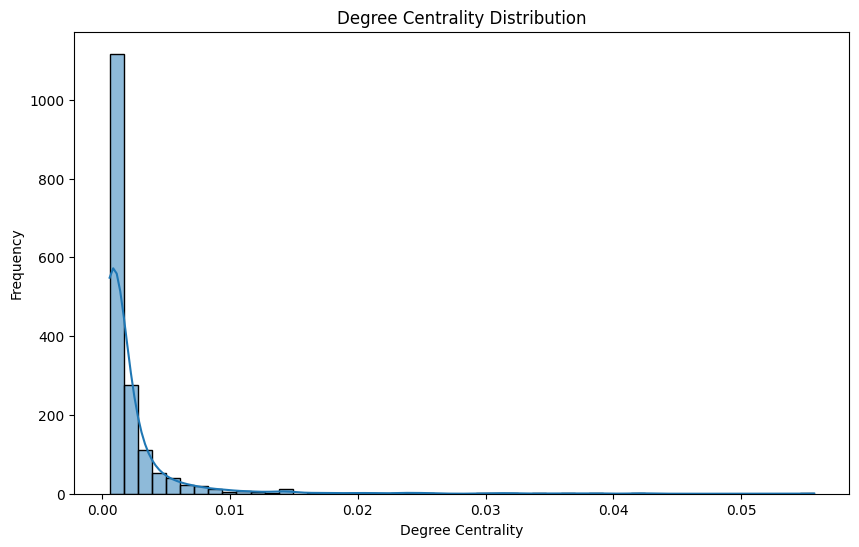

(    Node  Degree Centrality  Betweenness Centrality  Eigenvector Centrality
 66    67           0.055718                0.072071                0.268535
 12    13           0.042229                0.074362                0.116519
 30    31           0.042229                0.041643                0.228096
 195  196           0.038710                0.054543                0.179374
 53    54           0.038123                0.036112                0.178857
 62    63           0.036364                0.067880                0.120831
 141  142           0.034604                0.036251                0.170887
 268  269           0.032258                0.072991                0.109542
 49    50           0.031672                0.053045                0.060849
 10    11           0.031085                0.038958                0.152395,
     Node  Degree Centrality  Betweenness Centrality  Eigenvector Centrality
 12    13           0.042229                0.074362                0.11651

In [52]:
# Load the network, skipping the first line (header)
G__ = nx.read_edgelist(file_path, comments="%", nodetype=str)

# Compute centrality measures
degree_centrality = nx.degree_centrality(G__)
betweenness_centrality = nx.betweenness_centrality(G__)
eigenvector_centrality = nx.eigenvector_centrality(G__, max_iter=1000)

# Convert to DataFrame
centrality_df = pd.DataFrame(
        {
            "Node": list(G__.nodes()),
            "Degree Centrality": [degree_centrality[n] for n in G__.nodes()],
            "Betweenness Centrality": [betweenness_centrality[n] for n in G__.nodes()],
            "Eigenvector Centrality": [eigenvector_centrality[n] for n in G__.nodes()],
        }
)

# Get the top 10 nodes by each centrality measure
top_degree = centrality_df.nlargest(10, "Degree Centrality")
top_betweenness = centrality_df.nlargest(10, "Betweenness Centrality")
top_eigenvector = centrality_df.nlargest(10, "Eigenvector Centrality")

# Plot Degree Centrality Distribution
plt.figure(figsize=(10, 6))
sns.histplot(centrality_df["Degree Centrality"], bins=50, kde=True)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.show()

# Return tables with top nodes
top_degree, top_betweenness, top_eigenvector

In [53]:
G = G_dup.copy()
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))


# 1. Motif and Subgraph Analysis
def motif_analysis(G):
    triangles = sum(nx.triangles(G).values()) // 3
    cliques = list(nx.find_cliques(G))
    return triangles, cliques


triangles, cliques = motif_analysis(G)
print(f"Number of triangles: {triangles}")
print(f"Largest clique size: {max(map(len, cliques))}")


# 2. Assortativity and Homophily
def assortativity_analysis(G):
    degree_assortativity = assortativity.degree_assortativity_coefficient(G)
    return degree_assortativity


degree_assort = assortativity_analysis(G)
print(f"Degree Assortativity Coefficient: {degree_assort}")


# 3. Core-Periphery Analysis
def core_periphery_analysis(G):
    core_numbers = core.core_number(G)
    return core_numbers


core_numbers = core_periphery_analysis(G)
print(f"Max core number: {max(core_numbers.values())}")


# 4. Percolation and Resilience Analysis
def percolation_resilience(G):
    largest_cc = len(max(nx.connected_components(G), key=len))
    nodes_to_remove = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
    G_copy = G.copy()
    for node, _ in nodes_to_remove:
        G_copy.remove_node(node)
    new_largest_cc = len(max(nx.connected_components(G_copy), key=len))
    return largest_cc, new_largest_cc


largest_cc, new_largest_cc = percolation_resilience(G)
print(f"Largest connected component size before attack: {largest_cc}")
print(f"Largest connected component size after targeted attack: {new_largest_cc}")

Number of triangles: 96
Largest clique size: 4
Degree Assortativity Coefficient: -0.19159649734234405
Max core number: 7
Largest connected component size before attack: 1615
Largest connected component size after targeted attack: 1499


Number of triangles: 24
Top 10 hubs: [273, 348, 225, 25, 152, 300, 350, 478, 7, 9]
Max core number: 3


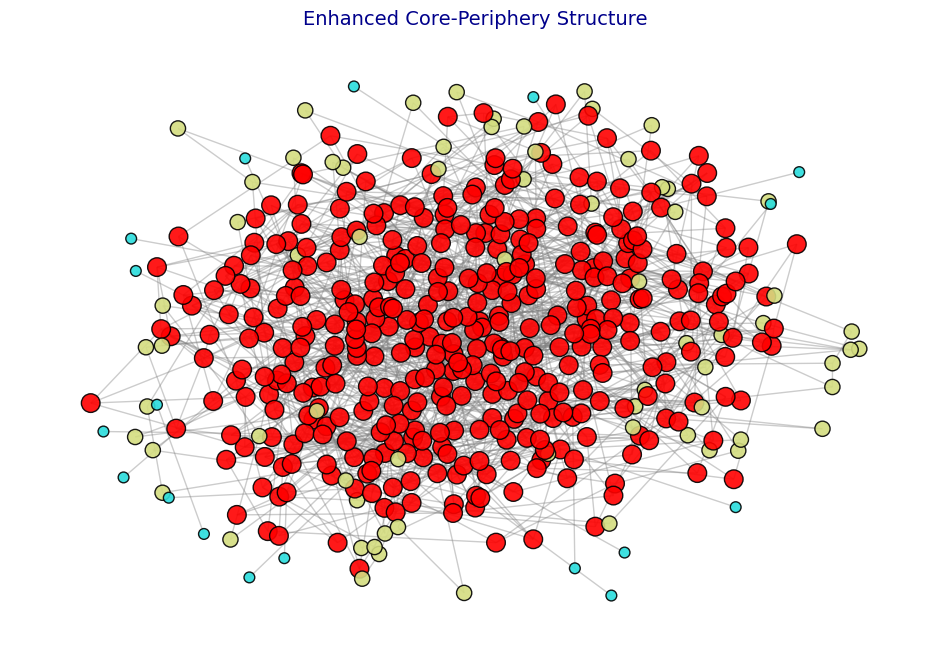

Largest connected component before attack: 493
Largest connected component after random attack: 438
Largest connected component after targeted attack: 438
Detected 22 communities


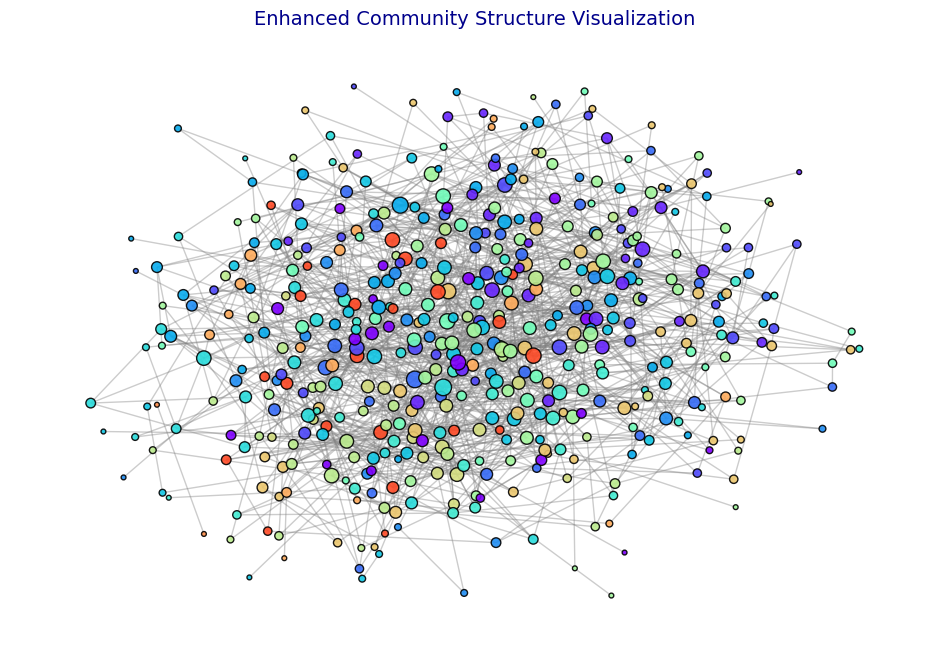

In [54]:
# Load the network (replace with actual dataset loading)
G = nx.erdos_renyi_graph(500, 0.01)  # Placeholder graph, replace with real dataset

# -----------------------------
# 1. Motif Analysis
# -----------------------------
num_triangles = sum(nx.triangles(G).values()) // 3
print(f"Number of triangles: {num_triangles}")

# -----------------------------
# 2. Degree Distribution & Hubs
# -----------------------------
# degrees = [d for _, d in G.degree()]
# plt.figure(figsize=(10, 5))
# sns.histplot(degrees, bins=20, kde=True, color="blue")
# plt.xlabel("Degree")
# plt.ylabel("Count")
# plt.title("Degree Distribution")
# plt.show()

# Identify hub nodes
degree_dict = dict(G.degree())
top_hubs = sorted(degree_dict, key=degree_dict.get, reverse=True)[:10]
print("Top 10 hubs:", top_hubs)

# -----------------------------
# 3. Core-Periphery Visualization
# -----------------------------
core_numbers = nx.core_number(G)
max_core = max(core_numbers.values())
print(f"Max core number: {max_core}")

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)  # Force-directed layout
node_sizes = [core_numbers[n] * 60 for n in G.nodes()]  # Scale by core number
node_colors = [core_numbers[n] for n in G.nodes()]  # Color nodes by core number

nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=cm.rainbow,
        alpha=0.9,
        edgecolors="black",
)
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="gray")
plt.title("Enhanced Core-Periphery Structure", fontsize=14, color="darkblue")
plt.axis("off")
plt.show()


# -----------------------------
# 4. Percolation Simulation (Random vs. Targeted Attack)
# -----------------------------
def percolation_attack(graph, attack_type="random", remove_fraction=0.1):
    G_copy = graph.copy()
    num_nodes = len(G_copy.nodes())
    num_remove = int(remove_fraction * num_nodes)

    if attack_type == "random":
        nodes_to_remove = np.random.choice(
                list(G_copy.nodes()), num_remove, replace=False
        )
    else:  # Targeted attack
        degree_dict = dict(G_copy.degree())
        nodes_to_remove = sorted(degree_dict, key=degree_dict.get, reverse=True)[
                          :num_remove
                          ]

    G_copy.remove_nodes_from(nodes_to_remove)
    largest_cc = max(nx.connected_components(G_copy), key=len)
    return len(largest_cc)


size_before = len(max(nx.connected_components(G), key=len))
size_after_random = percolation_attack(G, "random")
size_after_targeted = percolation_attack(G, "targeted")

print(f"Largest connected component before attack: {size_before}")
print(f"Largest connected component after random attack: {size_after_random}")
print(f"Largest connected component after targeted attack: {size_after_targeted}")

# -----------------------------
# 5. Community Structure Analysis with Beautiful Visualization
# -----------------------------
partition = community_louvain.best_partition(G)
num_communities = len(set(partition.values()))
print(f"Detected {num_communities} communities")

# Enhanced Visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)  # Force-directed layout
node_sizes = [G.degree(n) * 12 for n in G.nodes()]  # Scale node sizes by degree
node_colors = [partition[n] for n in G.nodes()]  # Color by community

nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=cm.rainbow,
        alpha=0.9,
        edgecolors="black",
)
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="gray")
plt.title("Enhanced Community Structure Visualization", fontsize=14, color="darkblue")
plt.axis("off")
plt.show()